# Import Module

In [1]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *
#import geopandas
from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof
import random

# Plotting modules 
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
#import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
from cartopy.util import add_cyclic_point

# Scikit-learn
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from scipy.optimize import minimize
from scipy.optimize import dual_annealing
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist

# Settings

### Variables

In [2]:
variables = ['tas', 'pr', 'psl', 'SW', 'LW']
truncations = [18, 18, 8, 28, 22]
TITLE = 'Multi-variate'
ylabel = '$E_{tot}$'

### Paths

In [3]:
path_official='/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/CFMIP/amip/'
path_PPE='/data/scratch/globc/peatier/CNRM-CM6-1_PPE/'
path_files='/data/home/globc/peatier/PPE/CNRMppe_error_decomposition/files/'
path_file_npy = '/data/home/globc/peatier/PPE/CNRMppe_save/PPE/ENSEMBLE2/files/npy/'

### List of members

In [4]:
nb_p_list = ['p311', 'p312', 'p314', 'p316',
                    'p317', 'p319', 'p320', 'p321', 'p322', 'p324', 'p325', 'p326', 
                    'p329', 'p330', 'p331', 'p332', 'p335', 'p336', 'p337' ,'p338', 
                    'p340', 'p341', 'p343', 'p344', 'p346', 'p347', 'p348', 'p349', 
                    'p350', 'p353', 'p355', 'p357', 'p359', 'p360', 
                    'p361', 'p363', 'p365', 'p367', 'p368', 'p369', 
                    'p372', 'p373', 'p374', 'p375', 'p376', 'p378', 'p381', 'p382', 
                    'p384', 'p386', 'p388', 'p389', 'p391', 'p392', 'p393', 
                    'p394', 'p395', 'p396', 'p398', 'p399', 'p400', 'p404', 
                    'p406', 'p407', 'p409', 'p410', 'p411', 'p412',
                    'p414','p416',
                    'p413','p419','p424','p426','p428','p421','p423',
                    'p425','p427','p429','p430','p436','p438','p431','p433',
                    'p442','p446','p443','p445','p447',
                    'p452','p454','p456','p458','p457','p459',
                    'p460','p465','p467','p469',
                    'p470','p471']

len(nb_p_list)

102

# Functions

In [5]:
def get_3D_tas_xarr(path, filename, variables):
#    “”"
#    This function read the netCDF file of monthly data, compute the radiative budget, perform a yearly mean and 
#    return a dataframe
#    “”"
    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    #
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    tas = df['tas']
    #
    return tas

In [6]:
def get_3D_pr_xarr(path, filename, variables):

    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    #
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    pr = df['pr']*86400 
    #
    return pr

In [7]:
def get_3D_psl_xarr(path, filename, variables):

    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    psl = df['psl']
    
    return psl

In [8]:
def get_3D_LW_xarr(path, filename, variables):

    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    LW = df['rlut']
    
    return LW

In [9]:
def get_3D_SW_xarr(path, filename, variables):

    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    SW = df['rsdt'] - df['rsut']
    
    return SW

In [10]:
def load_monthly_clim(path, filename, variables) :
    
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    df=file[variables].to_dataframe()
    
    # Compute Climatological Annual Cycle :
    df1=df.reset_index(level=['time', 'lat', 'lon'])
    df1['year']=pd.DatetimeIndex(df1['time']).year
    df1['month']=pd.DatetimeIndex(df1['time']).month
    
    #list_ind = []
    #cpt=0
    #for i in df1['year'] : 
    #    if i>1981 :
    #        list_ind.append(cpt)
    #        cpt+=1
    #    else : 
    #        cpt+=1
            
    #df2 = df1.drop(list_ind)
    df_mean=df1.groupby(['month', 'lat', 'lon']).mean()
    df_mean=df_mean.drop(columns='year')
    
    return df_mean

In [11]:
def MSE(mod, obs, W_rmse_2D) :
    diff_tmp = (mod - obs)**2 * W_rmse_2D
    diff = (diff_tmp.sum(['lat', 'lon']))
    return diff

In [12]:
def reconstruct_X(eofs_combined, pc, nb_dims) :
    X_rec_tmp = np.dot(eofs_combined.transpose(),pc)
    if nb_dims == 3 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat", "time"]).transpose('time', 'lat', 'lon')
    if nb_dims == 2 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat"]).transpose('lat', 'lon')
    
    X_rec['lat'] = eofs_combined['lat']
    X_rec['lon'] = eofs_combined['lon']
    return X_rec

In [13]:
def MSE_rec(rec_anom_mod_w, rec_anom_obs_w, Mean, W_rmse_2D) :
    mod = rec_anom_mod_w/W_eof_2D + Mean
    obs = rec_anom_obs_w/W_eof_2D + Mean
    diff = MSE(mod, obs, W_rmse_2D)
    return diff

In [14]:
def MultiLinReg_pred(LHS, X ,y, param_names) :

    LHS_df = pd.DataFrame(LHS)

    lhs = LHS_df.values
    #LHS_df

    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    N=len(LHS_df.values)
    tmp = [0]*N
    y_pred = [0]*N
    i=0
    Ycpt=0
    while i<N:
        
        tmp[i] = Coeffs.values*LHS_df.iloc[i]
        y_pred[i] = tmp[i].sum()+R
        i+=1

    #y_pred
    #members = arange(102,100102,1)
    #DFYpred = pd.DataFrame([y_pred, members], index=["y_pred", "members"]).transpose()
    return y_pred

# Get data 

In [21]:
path_file = path_files+'npy/'
Mean={}
for var in variables :
    filename = 'CNRMppe_decomposition_mean_'+str(var)+'.npy'
    Mean_tmp =  pd.read_pickle(path_file+filename).to_xarray().to_array()
    Mean[str(var)] = Mean_tmp[0,:,:].rename({'variable':'mode'})

### BEST observations - tas

In [22]:
path_observation = '/data/scratch/globc/peatier/obs_data/BEST/'
filename = 'Land_and_Ocean_LatLong1_regrid_1979-1981.nc'
var = 'tas'

In [23]:
# POUR LES OBSERVATIONS BEST ---- initial cells

path = path_observation

file =  xr.open_mfdataset(path+filename,combine='by_coords')
clim = file['climatology'].to_dataframe()#.drop(columns='month_number')
clim = pd.concat([clim, clim, clim]).reset_index('month_number')

df_obs=file['temperature'].to_dataframe().reset_index('time')
df_obs['clim'] = clim['climatology']
df_obs['tas'] = df_obs['temperature']+df_obs['clim']+273.15
variable_obs = 'ta'

In [24]:
obs = {}
obs[var] = df_obs[var].groupby(['lat','lon']).mean().to_xarray()

### GPCP observations - pr

In [25]:
path_observation = '/data/scratch/globc/peatier/obs_data/GPCP/regrid_CNRM/'
filename_obs = 'pr_mon_mean_197901-198112_regrid.nc'
var = 'pr'

In [26]:
## --- Initial method
path = path_observation
df_obs = load_monthly_clim(path, filename_obs, var)
obs[var] = df_obs[var].groupby(['lat','lon']).mean().to_xarray()

### CERES observations

In [27]:
path_observation = '/data/scratch/globc/peatier/obs_data/CERES/'
filename = 'CERES_EBAF-TOA_Ed4.1_Subset_200003-201910_regrid.nc'

In [28]:
# Load data and compute Annual Cycle :
file = xr.open_mfdataset(path_observation+filename,combine='by_coords')
#file
variables = ['toa_sw_all_mon','toa_lw_all_mon', 'toa_net_all_mon']
df_obs = load_monthly_clim(path_observation, filename, variables)
df_obs

toa_sw_all_mon  toa_lw_all_mon  toa_net_all_mon
month lat        lon                                                       
1     -88.927735 0.00000        344.953522      189.246185       -38.599289
                 1.40625        344.953522      189.246185       -38.599289
                 2.81250        344.953522      189.246185       -38.599289
                 4.21875        344.992493      189.144440       -38.531315
                 5.62500        345.007721      189.104630       -38.504715
...                                    ...             ...              ...
12     88.927735 352.96875        0.000000      171.476639      -171.476639
                 354.37500        0.000000      171.476639      -171.476639
                 355.78125        0.000000      171.500351      -171.500351
                 357.18750        0.000000      171.560974      -171.560974
                 358.59375        0.000000      171.560974      -171.560974

[393216 rows x 3 columns]

In [29]:
df_obs['SW'] =  df_obs['toa_net_all_mon'] + df_obs['toa_lw_all_mon']
obs['SW'] = df_obs.groupby(['lat','lon']).mean().to_xarray()

df_obs['LW'] =  df_obs['toa_lw_all_mon']
obs['LW'] = df_obs.groupby(['lat','lon']).mean().to_xarray()

### NCEP observations

In [30]:
path_observation =  '/data/scratch/globc/peatier/obs_data/NCEP/regrid_CNRM/'
filename_obs = 'psl_1m_1979-1981_NCEP_regrid.nc'

In [31]:
# Load data and compute Annual Cycle :
file = xr.open_mfdataset(path_observation+filename_obs,combine='by_coords')
#file
variables = ['psl']
df_obs = load_monthly_clim(path_observation, filename_obs, variables)
df_obs

psl
month lat        lon                     
1     -88.927735 0.00000     99413.804688
                 1.40625     99413.843750
                 2.81250     99413.851562
                 4.21875     99413.757812
                 5.62500     99413.578125
...                                   ...
12     88.927735 352.96875  101209.882812
                 354.37500  101209.617188
                 355.78125  101209.382812
                 357.18750  101209.171875
                 358.59375  101208.929688

[393216 rows x 1 columns]

In [32]:
obs['psl'] = df_obs.groupby(['lat','lon']).mean().to_xarray()

### Weighted anomaly

In [33]:
variables = ['tas', 'pr', 'psl', 'SW', 'LW']

In [34]:
X_obs = dict()
X_obs_w = dict()
for var in variables :
    W_eof_2D = np.load(path_files+'npy/W_eof_2D_'+str(var)+'.npy')
    W_eof_3D = np.load(path_files+'npy/W_eof_3D_'+str(var)+'.npy')
    W_rmse_2D = np.load(path_files+'npy/W_rmse_2D_'+str(var)+'.npy')

    ## --Observations
    X_obs[var] = obs[var] - Mean[var]
    X_obs_w[var] = X_obs[var]*W_eof_2D

### PPE simulations 

In [35]:
variables = ['tas', 'pr', 'psl', 'SW', 'LW']

In [36]:
cpt=0
path_file = path_files+'nc/'
pc_PPE = dict()

for var in variables :
    #trunc = truncations[cpt]
    
    ## --Get the pc_PPE 
    filename = 'CNRMppe_decomposition_EOFpc_'+var+'.nc'
    tmp = xr.open_dataset(path_file+filename)
    pc_PPE[var] = tmp['pcs'][:, :]
    
    cpt+=1

### Reference simulation p1

In [37]:
variables = ['tas', 'pr', 'psl']

In [38]:
# Reference simulation
path = path_PPE+'ENSEMBLE1/CNRM-CM6-1_amip_PPE/CNRM-CM6-1_amip_r1i1p1f2/'
filename = '*_CNRM-CM6-1_amip_*.nc'

p1_amip = dict()
diff_p1 = dict()
X_p1_w = dict()

## ----- tas
var = 'tas'
print(var)
p1_amip[var] = get_3D_tas_xarr(path, filename, [var])
    
## --Full error e(\theta_0)
mod = p1_amip[var]
observation = obs[var]
diff_p1[var] = MSE(mod, observation, W_rmse_2D)
    
## --Anom and weight
W_eof_2D = np.load(path_files+'npy/W_eof_2D_'+str(var)+'.npy')
X_p1 = p1_amip[var] - Mean[var]
X_p1_w[var] = X_p1*W_eof_2D

## ----- psl
var = 'psl'
print(var)
p1_amip[var] = get_3D_psl_xarr(path, filename, [var])
    
## --Full error e(\theta_0)
mod = p1_amip[var]
observation = obs[var]
diff_p1[var] = MSE(mod, observation, W_rmse_2D)
    
## --Anom and weight
W_eof_2D = np.load(path_files+'npy/W_eof_2D_'+str(var)+'.npy')
X_p1 = p1_amip[var] - Mean[var]
X_p1_w[var] = X_p1*W_eof_2D
    
## ------ SW

var = 'SW'
print(var)
p1_amip[var] = get_3D_SW_xarr(path, filename, ['rsut', 'rsdt'])

## --Full error e(\theta_0)
mod = p1_amip[var]
observation = obs[var]
diff_p1[var] = MSE(mod, observation, W_rmse_2D)
    
## --Anom and weight
W_eof_2D = np.load(path_files+'npy/W_eof_2D_'+str(var)+'.npy')
X_p1 = p1_amip[var] - Mean[var]
X_p1_w[var] = X_p1*W_eof_2D

## ------- LW

var = 'LW'
print(var)
p1_amip[var] = get_3D_LW_xarr(path, filename, ['rlut'])

## --Full error e(\theta_0)
mod = p1_amip[var]
observation = obs[var]
diff_p1[var] = MSE(mod, observation, W_rmse_2D)
    
## --Anom and weight
W_eof_2D = np.load(path_files+'npy/W_eof_2D_'+str(var)+'.npy')
X_p1 = p1_amip[var] - Mean[var]
X_p1_w[var] = X_p1*W_eof_2D

## -------- pr 
    
var = 'pr'
print(var)
p1_amip[var] = get_3D_pr_xarr(path, filename, ['pr'])
    
## --Full error e(\theta_0)
mod = p1_amip[var]
observation = obs[var]
diff_p1[var] = MSE(mod, observation, W_rmse_2D)
    
## --Anom and weight
W_eof_2D = np.load(path_files+'npy/W_eof_2D_'+str(var)+'.npy')
X_p1 = p1_amip[var] - Mean[var]
X_p1_w[var] = X_p1*W_eof_2D
 

tas
psl
SW
LW
pr


# EOF Solver

In [39]:
variables = ['tas', 'pr', 'psl', 'SW', 'LW']

In [40]:
# PPE amip simulations 
filename='*_amip_*.nc'
N=len(nb_p_list)
amip_tas = {}
amip_pr = {}
amip_psl = {}
amip_SW = {}
amip_LW = {}

i = 0
while i<N:
    nb_p = nb_p_list[i]
    #print(nb_p)
    path = path_PPE+'ENSEMBLE2/CNRM-CM6-1_amip_LHS500_PPE/CNRM-CM6-1_amip_r1i1'+str(nb_p)+'f2/'
    amip_tas[str(nb_p)] = get_3D_tas_xarr(path, filename, ['tas'])
    amip_pr[str(nb_p)] = get_3D_pr_xarr(path, filename, ['pr'])
    amip_psl[str(nb_p)] = get_3D_psl_xarr(path, filename, ['psl'])
    amip_SW[str(nb_p)] = get_3D_SW_xarr(path, filename, ['rsut', 'rsdt'])
    amip_LW[str(nb_p)] = get_3D_LW_xarr(path, filename, ['rlut'])
    i=i+1

In [41]:
n=len(nb_p_list)
amip_tas_list=[0]*(n+1)
amip_tas_list[0] = p1_amip['tas']#['tas']
amip_pr_list=[0]*(n+1)
amip_pr_list[0] = p1_amip['pr']#['pr']
amip_psl_list=[0]*(n+1)
amip_psl_list[0] = p1_amip['psl']#['psl']
amip_SW_list=[0]*(n+1)
amip_SW_list[0] = p1_amip['SW']#['rsut']
amip_LW_list=[0]*(n+1)
amip_LW_list[0] = p1_amip['LW']#['rlut']

i = 0
while i<n:
    nb_p = nb_p_list[i]
    #print(nb_p)
    tmp = amip_tas[str(nb_p)]
    amip_tas_list[i+1] = tmp
    tmp = amip_pr[str(nb_p)]
    amip_pr_list[i+1] = tmp
    tmp = amip_psl[str(nb_p)]
    amip_psl_list[i+1] = tmp
    tmp = amip_SW[str(nb_p)]
    amip_SW_list[i+1] = tmp
    tmp = amip_LW[str(nb_p)]
    amip_LW_list[i+1] = tmp
    i+=1

In [42]:
matrix = {}
matrix['tas'] = xr.combine_nested(amip_tas_list, concat_dim=['time'])
matrix['pr'] = xr.combine_nested(amip_pr_list, concat_dim=['time'])
matrix['psl'] = xr.combine_nested(amip_psl_list, concat_dim=['time'])
matrix['SW'] = xr.combine_nested(amip_SW_list, concat_dim=['time'])
matrix['LW'] = xr.combine_nested(amip_LW_list, concat_dim=['time'])

In [43]:
## --PPE simulations
mean = {}
anom = {}
anom_w = {}
for var in variables :
    mean[var] = matrix[var].mean(axis=0)
    anom[var] = matrix[var] - mean[var]
    anom_w[var] = (anom[var]*W_eof_3D)

In [44]:
# Create an EOF solver to do the EOF analysis. 
solver = {}
for var in variables :
    solver[var] = Eof(anom_w[var], center=False, weights=None)

In [45]:
eofs = {}
for var in variables :
    eofs[var] = solver[var].eofsAsCovariance(pcscaling=1)

In [46]:
lat = matrix['tas']['lat']
lon = matrix['tas']['lon']
eofs_nb = arange(1,104,1)
eofs_xr = {}
eofs_combined = {}

for var in variables :
    eofs_xr[var] = xr.DataArray(eofs[var], 
                   coords={'eofs': eofs_nb,'lat': lat,'lon': lon}, 
                   dims=["eofs", "lat", "lon"])#.to_dataset(name=var)
    ## --Combine the modes for reconstruction
    eofs_combined[var] = eofs_xr[var]

In [47]:
var_modes = solver['tas'].varianceFraction()
#var_modes

# Emulations 100 000

In [42]:
path = "/data/home/globc/peatier/PPE/CNRMppe/PPE/ENSEMBLE2/files/npy"
LHS = np.load(file=path+"/LHS100000_param_standard.npy")
X = np.load(file=path+"/X_EmulateurFeedbacksN.npy")
param_names = np.load(file=path+"/LHS_paramNames.npy")

pc_pred = {}
for var in variables :
    pc_pred[var] = []
    for i in range(0,30,1) :
        #print(i)
        y = pc_PPE[var][:, i]
        tmp = MultiLinReg_pred(LHS, X ,y, param_names)
        pc_pred[var].append(tmp)


In [43]:
df_pc_pred = {}
for var in variables :
    df_pc_pred[var] = pd.DataFrame(pc_pred[var][0], columns= ['EOF 1'])
    for i in range(1,30,1) :
        ind = 'EOF '+str(i+1)
        df_pc_pred[var][ind] = pc_pred[var][i]
#df_pc_pred

In [44]:
df_pc_pred['SW']

,EOF 1,EOF 2,EOF 3,EOF 4,EOF 5,EOF 6,EOF 7,EOF 8,EOF 9,EOF 10,...,EOF 21,EOF 22,EOF 23,EOF 24,EOF 25,EOF 26,EOF 27,EOF 28,EOF 29,EOF 30
0,0.469545,0.877526,-0.191922,0.966753,-0.063704,0.243773,0.780756,0.302086,0.104202,1.286628,...,0.398826,1.261376,-0.269145,0.988307,0.729935,0.050619,-0.063523,-0.624426,0.193172,0.260936
1,0.288395,-0.716343,-0.065012,1.781041,1.450278,-0.098546,1.355209,-0.536565,0.305650,-0.436598,...,-0.430887,-0.374111,0.813924,1.316457,-0.080451,0.428337,-1.734934,-0.388778,-0.915781,-0.193980
2,-0.596403,1.055428,-0.368145,-0.793781,-1.606194,0.338137,0.024182,0.333848,0.480555,0.359678,...,1.234544,1.131732,-0.249960,0.520119,0.971895,0.399149,0.415148,-0.475972,-0.638565,0.586595
3,0.173458,-0.155816,-0.840631,0.168080,1.034677,-0.583082,1.903569,-1.407469,1.008394,1.168816,...,0.098532,-0.673777,0.961188,-0.799295,-0.943506,-0.133691,0.101800,0.692679,-0.021353,0.190575
4,0.480972,0.276575,1.317608,0.043341,0.399288,-0.084492,-0.672578,1.412487,-0.707698,-0.281913,...,0.258421,0.501682,-1.243110,1.196646,1.374951,0.503952,0.560814,-0.452840,0.345986,0.655101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.484390,-1.665530,0.497648,0.831704,-1.084613,-0.376364,0.629561,-0.308476,0.804861,0.516254,...,0.045227,-0.582434,-0.215122,0.604298,-0.301301,0.091293,-0.387950,-0.528606,0.299253,0.917268
99996,-0.497007,-0.968395,-0.502236,0.440812,-0.082301,-0.222749,0.552510,-0.647528,-0.982867,-0.723635,...,-0.825243,0.007081,-1.400748,-0.440232,0.716007,-0.676955,-0.497371,-0.476016,-0.137885,0.528029
99997,-0.589315,1.286982,-0.474995,0.072422,-0.269948,0.366136,-0.149779,1.084405,-1.091350,0.955655,...,0.535806,0.534313,1.737535,0.068217,-0.418787,0.488818,-1.259329,-0.346786,-0.393022,-1.555849
99998,-0.702393,1.294930,-1.998083,0.778176,1.313872,0.702161,-1.530861,-0.788690,-1.112639,0.940143,...,0.594214,0.012486,0.504680,-0.426119,0.825753,-0.119814,-0.088380,0.245120,1.194370,-0.251652


# Calcule RMSE reconstructed (p)

In [45]:
#eofs = {}
#eofs_combined = {}
#for var in variables :
#    eofs[var] = []
#    for j in range(1, 104, 1) :
        ## --Get the eofs
#        eof_tmp = pd.read_pickle(path_files+"npy/CNRMppe_decomposition_EOFmap"+str(j)+"_"+var+".npy").to_xarray().to_array()
#        eof_tmp = eof_tmp[0,:,:].rename({'variable':'mode'})
#        eofs[var].append(eof_tmp)

    ## --Combine the modes for reconstruction
#    eofs_combined[var] = xr.combine_nested(eofs[var], concat_dim='eofs')

In [48]:
X_obs_w['psl'] = X_obs_w['psl']['psl']
X_obs_w['SW'] = X_obs_w['SW']['SW']
X_obs_w['LW'] = X_obs_w['LW']['LW']

In [49]:
## --Project and reconstruct the observations
U_obs = {}
X_obs_rec = {}
cpt = 0
for var in variables :
    print(var)
    trunc = truncations[cpt]
    U_obs[var] = solver[var].projectField(X_obs_w[var], neofs=trunc, weighted=False, eofscaling=1)
    X_obs_rec[var] = reconstruct_X(eofs_combined[var][0:trunc], pc=U_obs[var], nb_dims=2)
    cpt+=1

tas
pr
psl
SW
LW


In [56]:
## --Project and reconstruct p1
U_p1 = {}
X_p1_rec = {}
p_p1 = {}
cpt=0
for var in variables :
    print(var)
    trunc = truncations[cpt]
    U_p1[var] = solver[var].projectField(X_p1_w[var], neofs=trunc, weighted=False, 
                                         eofscaling=1)
    X_p1_rec[var] = reconstruct_X(eofs_combined[var][0:trunc], pc=U_p1[var], nb_dims=2)

    ## --Param. error p(\theta_0)
    p_p1[var] = MSE_rec(X_p1_rec[var], X_obs_rec[var], Mean[var], W_rmse_2D)
    cpt+=1
#U_p1['tas']

tas
pr
psl
SW
LW


In [57]:
nb_dims = 2
p_pred = {}
cpt=0
for var in variables :
    print(var)
    p_pred[var] = []
    for i in range(0,100000,1) : 
        pc = df_pc_pred[var].iloc[i]
        trunc = truncations[cpt]
        X_mod_rec = reconstruct_X(eofs_combined[var][0:trunc], pc[0:trunc], nb_dims)
        tmp = MSE_rec(X_mod_rec, X_obs_rec[var], Mean[var], W_rmse_2D)
        p_pred[var].append(float(tmp))
    df_pc_pred[var]['p'] = p_pred[var]
    cpt+=1
    #df_pc_pred

tas
pr
psl
SW
LW


In [83]:
## --Save 
for var in variables :
    print(var)
    df_pc_pred[var].to_pickle(path_files+'pkl/df_pc_pred_'+var+'.pkl')

tas
pr
psl
SW
LW


##  Pair-wise comparison

In [16]:
## to read pickles -- 
df_pc_pred = {}
for var in variables :
     df_pc_pred[var] = pd.read_pickle(path_files+'pkl/df_pc_pred_'+var+'.pkl')

In [18]:
df_pc_pred[var]

,EOF 1,EOF 2,EOF 3,EOF 4,EOF 5,EOF 6,EOF 7,EOF 8,EOF 9,EOF 10,...,EOF 22,EOF 23,EOF 24,EOF 25,EOF 26,EOF 27,EOF 28,EOF 29,EOF 30,p
0,0.053160,0.591416,0.177104,0.866376,0.718467,0.659540,-0.043037,0.556143,0.368303,-1.033655,...,0.202013,-0.471100,-0.509039,-0.773982,0.442059,-0.092687,-0.211744,-0.520401,-0.842986,1.036283
1,-0.259237,0.647073,-0.452515,1.409053,0.870643,0.667772,-1.261793,-0.218841,-0.226251,-0.316316,...,0.040629,-1.070933,-0.574019,0.512824,-0.952646,-0.372224,0.465143,-1.096917,-0.864408,1.100781
2,-0.050450,0.146491,-1.425103,-0.870566,-0.249998,-0.354165,-0.285270,-1.353141,0.577560,-0.725585,...,-1.416943,-0.419147,0.064411,-0.348624,0.894631,0.039038,0.011329,0.555142,-0.556936,1.389311
3,1.133615,-1.250214,-1.322137,1.910634,1.905300,0.142851,-0.127473,0.419342,0.802691,0.352713,...,1.351010,-0.671949,0.898724,1.412535,-0.396175,-1.204603,-0.037219,-0.788415,-0.646077,2.314204
4,-0.657846,-0.100945,2.477285,-0.208477,-0.485037,-0.204115,-0.430936,-0.878425,0.267369,-0.884294,...,-0.649098,0.168028,-1.075322,-0.525468,0.578817,-0.178247,-0.220270,0.039307,-0.470260,0.807454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-0.349083,0.723257,-0.359346,-0.372656,-1.266572,-0.090595,-0.046930,1.096434,-0.197282,0.595198,...,0.360153,0.035420,-0.266770,1.091658,-0.163661,0.009620,0.292299,0.639013,-0.779151,1.127336
99996,0.925938,0.211934,-0.261631,0.588695,-0.560485,0.142986,-1.146804,-0.050800,-1.661729,-0.765650,...,-0.114483,0.461471,-0.051980,-0.200289,-0.220475,-0.340032,-0.077185,0.069548,0.812357,2.075135
99997,-1.077140,0.734859,-1.400953,-0.835652,0.436109,1.047429,1.265766,-0.080022,-0.185519,-1.106912,...,0.829382,-1.435375,0.078602,-0.480680,-0.615113,0.718826,0.272834,-0.851228,0.142878,1.370659
99998,1.019538,1.927900,-0.051013,0.596887,0.884314,0.370158,1.676687,-0.526902,-1.004441,1.178439,...,0.455383,-1.179807,-0.518795,-0.934360,-0.567415,1.080923,-0.117162,1.164495,-0.456821,2.490433


In [54]:
float(U_obs['tas'][0])

-0.6431345615717069

In [135]:
df_fig = pd.DataFrame()
for var in variables :
    df_fig[var] = df_pc_pred[var]['p']
    df_fig[var+' EOF1'] = (df_pc_pred[var]['EOF 1'] - float(U_obs[var][0]))**2
    df_fig[var+' EOF2'] = (df_pc_pred[var]['EOF 2'] - float(U_obs[var][1]))**2
    df_fig[var+' EOF3'] = (df_pc_pred[var]['EOF 3'] - float(U_obs[var][2]))**2
    df_fig[var+' EOF4'] = (df_pc_pred[var]['EOF 4'] - float(U_obs[var][3]))**2
    df_fig[var+' EOF5'] = (df_pc_pred[var]['EOF 5'] - float(U_obs[var][4]))**2
df_fig

,tas,tas EOF1,tas EOF2,tas EOF3,tas EOF4,tas EOF5,pr,pr EOF1,pr EOF2,pr EOF3,...,SW EOF2,SW EOF3,SW EOF4,SW EOF5,LW,LW EOF1,LW EOF2,LW EOF3,LW EOF4,LW EOF5
0,1.036283,0.484827,1.185959,2.512677,1.157669,8.572028,1.940961,0.963592,5.203796,0.124995,...,0.541793,0.271432,0.000703,0.672185,54.028926,0.239735,0.712886,1.994608,0.139679,5.888939
1,1.100781,0.147377,1.310280,4.905168,2.619954,7.704102,1.664970,0.309519,6.199464,0.092045,...,5.428597,0.419777,0.620601,5.446859,75.285424,0.369172,3.663870,1.231506,0.371589,5.784973
2,1.389311,0.351275,0.414855,10.159196,0.436909,15.180903,2.189384,4.755363,0.910810,0.722514,...,0.311547,0.118866,3.193509,0.522182,79.638471,0.069463,1.833075,8.255801,1.392033,0.662354
3,2.314204,3.156840,0.566426,9.513420,4.495285,3.030974,2.707981,3.120075,7.458878,1.329437,...,3.130804,0.016312,0.680920,3.679679,155.535449,1.933114,4.256756,6.897453,0.052458,7.105159
4,0.807454,0.000216,0.157337,0.511279,0.000001,17.067697,2.094532,2.618559,5.053139,0.309067,...,1.787615,4.123021,0.902343,1.645732,60.276251,0.002681,0.071121,5.235984,1.836516,5.151259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.127336,0.086466,1.490497,4.501154,0.026595,24.136012,1.548572,4.170658,0.239700,0.080964,...,10.752642,1.465459,0.026100,0.040417,83.500647,0.938541,0.894733,5.146728,0.311780,0.002230
99996,2.075135,2.461990,0.503442,4.096081,0.637234,17.696787,2.491209,4.935202,0.493570,2.646547,...,6.666654,0.044385,0.305197,0.642036,81.674794,0.503847,0.176222,6.574936,0.844808,1.731274
99997,1.370659,0.188361,1.518961,10.005829,0.391972,10.305128,1.852856,1.652306,2.863119,0.209546,...,0.106674,0.056605,0.847940,0.376535,73.506185,0.095921,4.204733,3.694678,0.750455,1.421087
99998,2.490433,2.764479,5.883059,3.287912,0.650381,7.628401,1.337949,0.275205,1.900562,3.255204,...,0.101546,1.651660,0.046260,4.828760,52.929723,0.045868,2.914811,0.494410,4.940297,1.443583


In [136]:
var_df_fig = df_fig.columns.values.tolist()
var_df_fig

['tas',
 'tas EOF1',
 'tas EOF2',
 'tas EOF3',
 'tas EOF4',
 'tas EOF5',
 'pr',
 'pr EOF1',
 'pr EOF2',
 'pr EOF3',
 'pr EOF4',
 'pr EOF5',
 'psl',
 'psl EOF1',
 'psl EOF2',
 'psl EOF3',
 'psl EOF4',
 'psl EOF5',
 'SW',
 'SW EOF1',
 'SW EOF2',
 'SW EOF3',
 'SW EOF4',
 'SW EOF5',
 'LW',
 'LW EOF1',
 'LW EOF2',
 'LW EOF3',
 'LW EOF4',
 'LW EOF5']

In [137]:
df_fig_final = pd.DataFrame()

for var1 in var_df_fig :
    tmp_list = []
    tmp = df_fig.sort_values(by = var1)
    
    for var2 in var_df_fig :
        PPE_mean = tmp[var2].mean()
        best_mean = tmp[var2][0:999].mean()
        change = (best_mean - PPE_mean)*(100/PPE_mean)
        tmp_list.append(change)
        
    ## --- update dataframe ---
    df_fig_final[var1] = tmp_list
    

In [138]:
df_fig_final[' '] = var_df_fig
df_fig_final = df_fig_final.set_index(' ')
df_fig_final

,tas,tas EOF1,tas EOF2,tas EOF3,tas EOF4,tas EOF5,pr,pr EOF1,pr EOF2,pr EOF3,...,SW EOF2,SW EOF3,SW EOF4,SW EOF5,LW,LW EOF1,LW EOF2,LW EOF3,LW EOF4,LW EOF5
,,,,,,,,,,,,,,,,,,,,,
tas,-68.416862,-36.502859,-10.191628,-6.272842,-3.311913,-22.556261,3.755844,15.228441,49.998452,-13.784500,...,-14.541826,9.024370,-7.432649,1.352949,14.593899,-10.248202,21.693714,23.641545,-4.692241,27.600205
tas EOF1,-94.847694,-99.993514,-6.822922,10.369130,-2.010504,-4.524963,3.484595,26.932281,119.130072,-37.688412,...,-33.631887,24.969055,-15.715385,-6.119631,39.363689,-25.926937,78.734409,12.961491,-9.487882,42.121405
tas EOF2,-82.322748,-5.299590,-99.994616,10.525021,-4.163696,-5.304167,174.179889,199.681060,60.663292,4.755779,...,9.363508,18.465815,36.440561,-2.060625,235.104034,1.313288,9.866937,408.855301,1.196597,75.244871
tas EOF3,-74.188234,4.622549,7.938945,-99.975355,0.105578,0.723468,-49.719742,-30.480385,11.126115,-15.822552,...,12.337991,14.333199,1.762209,29.790480,-67.801672,0.813508,-44.904486,-31.370868,-9.614055,15.616138
tas EOF4,-45.620445,-6.521432,-3.818940,-12.035023,-99.993981,-26.932996,-33.113896,-4.681618,7.368810,-4.405185,...,50.769433,-8.360930,9.203817,-10.007977,-23.948108,-8.555969,-18.721793,-15.095765,2.867991,-12.107612
tas EOF5,-58.673849,3.217738,0.469621,8.136601,-1.257248,-87.644781,-13.494722,-38.695282,10.829305,8.435335,...,-33.180354,-16.214298,-20.218327,12.643336,-43.210301,-1.427095,-5.161972,-52.732810,-0.905917,34.953186
pr,-18.550102,8.197816,11.115692,-18.767739,-4.428384,-23.904993,-69.625334,-45.508180,-30.197527,-3.260801,...,3.541850,-17.249677,-24.360714,-2.130170,-55.823585,0.205782,-22.108564,-45.264638,-1.302666,-21.271624
pr EOF1,-58.889280,15.601961,21.374236,-41.678549,-1.880035,-82.974147,-94.657200,-99.980961,-32.349016,1.384416,...,-43.985971,-35.345341,-51.184164,19.216241,-93.207888,3.192615,-22.727836,-88.913769,-0.017403,-16.349375
pr EOF2,44.849714,25.766155,13.671965,5.232382,-18.357338,20.523171,-88.367875,-33.688056,-99.977215,0.299087,...,85.853555,-36.038183,-9.375330,-45.279431,-75.370701,-2.270959,-72.251546,-54.037129,0.591715,-83.853311


In [94]:
cmap=cm.get_cmap('RdYlGn_r', 12)
cmap

In [127]:
df_test = pd.DataFrame()

for var1 in variables :
    tmp_list = []
    tmp = df_fig.sort_values(by = var1+'_p')
    index_list = []
    
    for var2 in variables :
        PPE_mean = tmp[var2+'_p'].mean()
        best_mean = tmp[var2+'_p'][0:999].mean()
        change = (best_mean - PPE_mean)*(100/PPE_mean)
        tmp_list.append(change)
        index_list.append(var2+'_p')
        
    ## --- update dataframe ---
    df_test[var1] = tmp_list

In [133]:
df_test[' '] = variables
df_test = df_test.set_index(' ')
df_test

,tas,pr,psl,SW,LW
,,,,,
tas,-68.416862,3.755844,-23.887118,-10.193987,14.593899
pr,-18.550102,-69.625334,-48.076226,-35.393415,-55.823585
psl,-10.573337,-43.490157,-92.344329,-56.875405,-35.459534
SW,-31.412171,-31.630196,-41.137571,-78.417797,-43.478382
LW,-32.452371,-41.097932,-38.132201,-39.682582,-74.255928


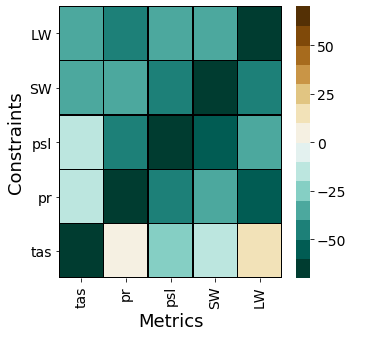

In [168]:
import seaborn as sns

plt.figure(figsize=(5, 5))
ax=plt.gca()
    

ax = sns.heatmap(df_test,vmin=-70, vmax=70, cmap=cm.get_cmap('BrBG_r', 14), linewidth=.5, 
            linecolor='black', cbar_kws={'label': ' '})
ax.set_ylim(0, 5)
ax.figure.axes[-1].yaxis.label.set_size(18)
ax.figure.axes[-1].tick_params(axis='both', which='major', labelsize=14)
plt.yticks(fontsize=14, rotation = 0)
plt.xticks(fontsize=14, rotation = 90)
plt.ylabel('Constraints', fontsize=18)
plt.xlabel('Metrics', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)

# Save figure ---------------
name_fig='Pairwise_RMSE.png'
plt.savefig("/data/home/globc/peatier/PPE/figures/"+name_fig, 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)
#----------------------------


plt.show()

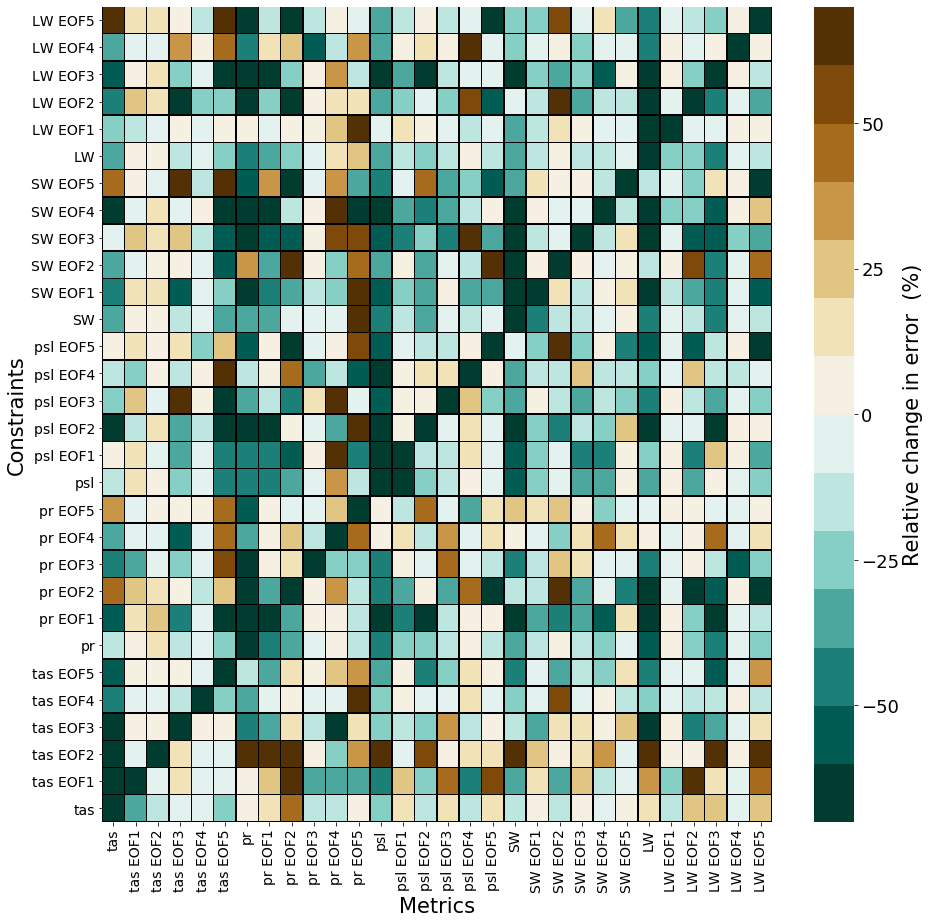

In [169]:
plt.figure(figsize=(15, 15))
#ax=plt.gca()
    

ax = sns.heatmap(df_fig_final,vmin=-70, vmax=70, cmap=cm.get_cmap('BrBG_r', 14), linewidth=.5, 
            linecolor='black', cbar_kws={'label': 'Relative change in error  (%)'})
ax.set_ylim(0, 30)
ax.figure.axes[-1].yaxis.label.set_size(21)
ax.figure.axes[-1].tick_params(axis='both', which='major', labelsize=18)
plt.yticks(fontsize=14, rotation = 0)
plt.xticks(fontsize=14, rotation = 90)
plt.ylabel('Constraints', fontsize=21)
plt.xlabel('Metrics', fontsize=21)
ax.tick_params(axis='both', which='major', labelsize=14)

# Save figure ---------------
name_fig='Pairwise_EOF.png'
plt.savefig("/data/home/globc/peatier/PPE/figures/"+name_fig, 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)
#----------------------------


plt.show()

## Erreure multi-variée 

In [52]:
## -- Create list for column names 
col = []
for i in range(1,19,1) :
    col.append('EOF '+str(i))
col.append('p')
    
## -- load data 
df_pc_pred = {}
for var in variables :
    tmp = np.load(path_files+'npy/df_pc_pred_'+var+'.npy')
    df_pc_pred[var] = pd.DataFrame(tmp, columns=col)


In [87]:
for var in variables :
    df_pc_pred[var]['p_norm'] = df_pc_pred[var]['p']/float(p_p1[var])

df_multi = pd.DataFrame()
df_multi['p_tas_norm'] = df_pc_pred['tas']['p_norm']
df_multi['p_pr_norm'] = df_pc_pred['pr']['p_norm']
df_multi['p_multi'] = (df_multi['p_tas_norm']+df_multi['p_pr_norm'])/2
df_multi

,p_tas_norm,p_pr_norm,p_multi
0,1.032369,0.117070,0.574719
1,1.128243,0.128293,0.628268
2,1.216241,0.198015,0.707128
3,2.549504,0.215224,1.382364
4,0.616506,0.170535,0.393520
...,...,...,...
99995,0.681427,0.217181,0.449304
99996,1.684021,0.228029,0.956025
99997,1.206478,0.137340,0.671909
99998,2.407247,0.055540,1.231394


In [88]:
## -- Identify best candidate 
best_index = df_multi['p_multi'].idxmin()
best_p_multi = df_multi['p_multi'].iloc[best_index]
best_p_tas_norm = df_multi['p_tas_norm'].iloc[best_index]
best_p_pr_norm = df_multi['p_pr_norm'].iloc[best_index]

In [89]:
best_p_pr_norm

0.22101359030530118

# ---------- Just to select candidates -------------

## Selection lower than ref

In [90]:
cpt_drop=[]
cpt=0
for i in df_multi['p_multi'] : 
    if i>1.0 : 
        cpt_drop.append(cpt)
        cpt+=1
    else :
        cpt+=1

In [91]:
df_pc_best = {}
for var in variables :
    tmp = df_pc_pred[var].copy()
    df_pc_best[var] = tmp.drop(cpt_drop)
    df_pc_best[var] = df_pc_best[var].reset_index()
df_pc_best[var]

,index,EOF 1,EOF 2,EOF 3,EOF 4,EOF 5,EOF 6,EOF 7,EOF 8,EOF 9,...,EOF 11,EOF 12,EOF 13,EOF 14,EOF 15,EOF 16,EOF 17,EOF 18,p,p_norm
0,0,0.670288,-0.790521,0.029989,0.785455,-0.062077,-0.609458,0.876451,0.264218,0.304293,...,-0.441925,0.086703,-0.451636,-0.143881,-0.444148,0.631852,1.073848,0.874232,1.172499,0.117070
1,1,1.095571,-0.999211,-0.020168,0.917900,1.258599,0.056930,0.301744,0.382213,-0.473981,...,0.056880,0.426517,1.160920,-0.724864,0.372936,1.139522,1.717078,0.408300,1.284901,0.128293
2,2,-0.528764,0.536298,0.526450,-0.336078,-0.467179,-0.248779,0.756709,-0.596996,0.885692,...,-0.150732,0.146812,0.263039,-0.820059,0.395175,1.099081,-0.034834,1.166305,1.983196,0.198015
3,4,0.033719,-0.757257,-0.879496,-0.669543,-0.347216,0.714384,-0.486613,0.006203,-0.952759,...,0.651977,-0.603233,0.330525,-1.224742,0.805191,0.000496,1.089089,0.698498,1.707968,0.170535
4,5,0.061282,-1.834802,-0.907971,-1.587969,-0.097403,1.194729,-0.711546,-0.793513,-0.235365,...,0.024402,-0.971234,0.060953,-0.418991,-0.262695,-0.821049,-0.254316,-0.621489,2.343570,0.233997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79956,99994,-0.862107,0.145841,-0.228162,-0.548818,0.655254,0.783710,-0.539680,0.971426,0.503236,...,0.458142,0.228707,0.396075,0.178940,-0.091134,-0.963954,0.296419,0.339819,2.616702,0.261268
79957,99995,-0.390304,1.001070,-0.608099,0.483360,1.211396,-0.429256,0.116171,0.477464,-0.038712,...,0.533115,1.318071,-0.001952,1.346793,1.088495,0.407556,0.252647,-0.074069,2.175151,0.217181
79958,99996,-0.569616,0.788116,1.303263,1.504314,-0.452277,0.162624,-0.862755,0.828430,-1.373984,...,0.543779,1.020082,0.178340,-1.091796,-0.174536,-2.033043,0.699975,1.141386,2.283799,0.228029
79959,99997,0.366495,-0.201414,0.134204,0.175639,0.034514,0.019771,1.030345,-2.307188,-0.869328,...,-1.312696,-0.685861,-1.054423,0.609246,0.402423,2.497775,-0.671741,0.110514,1.375516,0.137340


In [42]:
## -- save
np.save(path_files+'npy/df_pc_low_tas.npy', df_pc_best['tas'].values)
np.save(path_files+'npy/df_pc_low_pr.npy', df_pc_best['pr'].values)

## Compute distances and drop near-neighbors

In [40]:
def Drop_candidates(df_pc_best, nb_drop, d_mean) :
    d_list = {}
    df_pc_best_shuffle = {}
    for var in variables :
        print(var)
        ## -- Shuffle the data :
        #df_pc_best_shuffle[var] = df_pc_best[var].sample(frac=1).reset_index().drop('level_0', axis=1)
    
        ## -- Compute inter-point distances :
        nb_dims = 2
        d_list[var] = []
        ind1_list = []
        ind2_list = []
        for i in range(0,int(len(df_pc_best[var])-1),2) : 
            #print(i)
            pc1 = df_pc_best[var].iloc[i][1:-1]
            pc2 = df_pc_best[var].iloc[i+1][1:-1]
    
            X_pc1 = reconstruct_X(eofs_combined[var], pc1[0:18], nb_dims)
            X_pc2 = reconstruct_X(eofs_combined[var], pc2[0:18], nb_dims)
    
            tmp = MSE_rec(X_pc1, X_pc2, Mean[var], W_rmse_2D)
            d_list[var].append(float(tmp))
            ind1_list.append(i)
            ind2_list.append(i+1)
        
    ## -- Sort distances and select index to drop :
    df_d = pd.DataFrame(d_list['tas'], columns=['d_tas'])
    df_d['d_pr'] = d_list['pr']
    df_d['d_multi'] = df_d['d_tas']/d_mean['tas'] + df_d['d_pr']/d_mean['pr']
    df_d['ind1'] = ind1_list
    df_d['ind2'] = ind2_list
    df_d_sorted = df_d.sort_values(by='d_multi').reset_index()
    print(df_d_sorted)
    ind_drop = []
    for i in range(0, nb_drop, 1) :
        #print(i)
        ind_drop_tmp = random.choice([df_d_sorted['ind1'].iloc[i], df_d_sorted['ind2'].iloc[i]])
        #print(df_d_sorted['ind1'].iloc[i], df_d_sorted['ind2'].iloc[i])
        #print(ind_drop_tmp)
        ind_drop.append(ind_drop_tmp)
    #print(ind_drop)
    ## -- Drop candidate : 
    df_res = {}
    for var in variables :
        df_res[var] = df_pc_best[var].drop(ind_drop)
    
    ## -- Return DataFrame - 1 candidates : 
    return df_res

In [44]:
d_list = {}
d_mean = {}
for var in variables :
        print(var)
        
        ## -- Compute inter-point distances :
        nb_dims = 2
        d_list[var] = []
        for i in range(0,int(len(df_pc_best[var])-1),2) : 
            #print(i)
            pc1 = df_pc_best[var].iloc[i][1:-1]
            pc2 = df_pc_best[var].iloc[i+1][1:-1]
    
            X_pc1 = reconstruct_X(eofs_combined[var], pc1[0:18], nb_dims)
            X_pc2 = reconstruct_X(eofs_combined[var], pc2[0:18], nb_dims)
    
            tmp = MSE_rec(X_pc1, X_pc2, Mean[var], W_rmse_2D)
            d_list[var].append(float(tmp))
            
        d_mean[var] = float(xr.DataArray(d_list[var]).mean())

tas
pr


In [50]:
## -- Create list for column names 
col = []
for i in range(0,58,1) :
    j = (59-i)
    col.append('index_'+str(j))
col.append('index')

for i in range(1,19,1) :
    col.append('EOF '+str(i))
col.append('p')
col.append('p_norm')

## -- load data
df_pc_best = {}
for var in variables :
    tmp = np.load(path_files+'npy/df_pc_best_'+var+'.npy')
    df_pc_best[var] = pd.DataFrame(tmp, columns=col)

In [56]:
len(df[var])/2

7554.5

In [64]:
nb_drop = 1
#df = df_pc_best.copy()
cpt=0
while len(df['tas']['p']) > 5 :
    print(cpt)
    df = Drop_candidates(df, nb_drop, d_mean)
    df['tas'].rename(columns = {'level_0':'index_'+str(cpt)}, inplace = True)
    df['pr'].rename(columns = {'level_0':'index_'+str(cpt)}, inplace = True)
    df['tas'] = df['tas'].reset_index()
    df['pr'] = df['pr'].reset_index()
    print(df)
    cpt+=1

0
tas
pr
   index       d_tas        d_pr     d_multi  ind1  ind2
0      2   14.494536   32.706475   52.453097     4     5
1      7   36.644572   82.297297  132.194506    14    15
2      1   55.036520  125.224345  200.271053     2     3
3      3   67.343913  154.340168  246.241750     6     7
4      4   67.934398  155.542249  248.239758     8     9
5      8   80.565961  181.811841  291.571955    16    17
6      0   81.422451  182.672999  293.529900     0     1
7      5  106.260738  234.395690  378.808313    10    11
8      6  160.215589  366.024861  584.588885    12    13
{'tas':     level_0  index_0  index_8  index_7  index_6  index_5  index_4  index_3  \
0         0        0        0        0        0        0        0        0   
1         1        2        3        3        3        4        6        7   
2         2        4        5        6        6        7       11       12   
3         3        5        7        9        9       11       16       17   
4         5        8   

{'tas':     level_0  index_1  index_0  index_8  index_7  index_6  index_5  index_4  \
0         0        0        0        0        0        0        0        0   
1         1        1        2        3        3        3        4        6   
2         2        2        4        5        6        6        7       11   
3         3        3        5        7        9        9       11       16   
4         4        5        8       11       15       15       17       24   
5         5        6        9       13       17       19       21       28   
6         6        7       11       15       19       23       25       32   
7         7        8       12       16       20       25       28       35   
8         8        9       13       18       22       27       33       40   
9         9       10       15       21       26       31       37       44   
10       10       11       17       25       30       36       43       51   
11       11       12       18       26       31       37

pr
   index      d_tas        d_pr     d_multi  ind1  ind2
0      3   5.977380   13.217555   21.343168     6     7
1      7  12.845740   29.373612   46.899338    14    15
2      2  13.604798   30.979769   49.532625     4     5
3      6  17.513669   40.473330   64.395454    12    13
4      1  20.760414   47.988116   76.345772     2     3
5      4  30.039487   69.924176  110.988426     8     9
6      0  31.623402   73.760931  117.000202     0     1
7      5  73.508081  169.377594  269.750684    10    11
{'tas':     level_0  index_3  index_2  index_1  index_0  index_8  index_7  index_6  \
0         0        0        0        0        0        0        0        0   
1         1        1        1        1        2        3        3        3   
2         2        2        2        2        4        5        6        6   
3         3        3        3        3        5        7        9        9   
4         4        4        4        5        8       11       15       15   
5         5      

pr
   index      d_tas       d_pr    d_multi  ind1  ind2
0      2   4.425061   9.653649  15.660463     4     5
1      1   6.351467  14.138316  22.778578     2     3
2      3   7.044384  15.971373  25.573249     6     7
3      0   9.425788  21.564820  34.425376     0     1
4      5  16.768094  36.382218  59.131131    10    11
5      4  17.019577  39.623058  62.889357     8     9
{'tas':     level_0  index_6  index_5  index_4  index_3  index_2  index_1  index_0  \
0         0        0        0        0        0        0        0        0   
1         1        1        1        1        1        1        1        2   
2         2        2        2        2        2        2        2        4   
3         3        3        3        3        3        3        3        5   
4         5        5        5        5        5        5        6        9   
5         6        6        6        7        7        7        8       12   
6         7        7        7        8        8        8        9

   index      d_tas       d_pr    d_multi  ind1  ind2
0      2   1.723256   3.153553   5.453183     4     5
1      0   1.961530   3.745405   6.373190     0     1
2      3   3.590575   7.687014  12.551500     6     7
3      4   5.155571  11.181249  18.175379     8     9
4      1  15.275186  31.932378  52.576746     2     3
{'tas':    level_0  index_9  index_8  index_7  index_6  index_5  index_4  index_3  \
0        0        0        0        0        0        0        0        0   
1        1        1        1        1        1        1        1        1   
2        2        2        2        2        2        2        2        2   
3        3        3        4        5        5        5        5        5   
4        5        6        7        8        8        8        9        9   
5        6        7        8        9        9        9       10       11   
6        7        8        9       10       10       10       11       12   
7        8        9       10       11       11      

   index     d_tas       d_pr    d_multi  ind1  ind2
0      2  1.796361   3.283609   5.680551     4     5
1      3  2.848942   5.699803   9.533414     6     7
2      0  4.245871   6.184937  11.747292     0     1
3      1  8.249745  14.749411  25.735703     2     3
{'tas':    level_0  index_11  index_10  index_9  index_8  index_7  index_6  index_5  \
0        0         0         0        0        0        0        0        0   
1        1         2         2        2        2        2        2        2   
2        2         3         3        3        4        5        5        5   
3        3         4         5        6        7        8        8        8   
4        5         6         7        8        9       10       10       10   
5        6         7         8        9       10       11       11       12   
6        7         8         9       10       11       12       13       14   

   index_4  index_3  ...    EOF 11    EOF 12    EOF 13    EOF 14    EOF 15  \
0        0      

In [67]:
df['pr']

,level_0,index_13,index_12,index_11,index_10,index_9,index_8,index_7,index_6,index_5,...,EOF 11,EOF 12,EOF 13,EOF 14,EOF 15,EOF 16,EOF 17,EOF 18,p,p_norm
0,0,0,0,0,0,0,0,0,0,0,...,0.414431,0.577768,-0.709015,0.930001,-0.726232,1.792210,0.708825,-0.047516,1.363386,0.171719
1,1,1,1,2,2,2,2,2,2,2,...,0.307360,0.966768,1.775389,0.926481,0.985074,1.677218,-0.188288,-0.449768,3.157703,0.397714
2,2,2,2,3,3,3,4,5,5,5,...,0.073431,-1.126255,0.739749,-0.329881,-0.344687,-0.159927,-1.267141,-0.677843,2.950348,0.371598
3,3,3,3,4,5,6,7,8,8,8,...,0.199147,0.986599,-0.088910,0.363315,0.200740,-0.035904,0.875884,0.480054,2.761687,0.347836
4,4,5,6,7,8,9,10,11,11,12,...,0.158730,-0.342285,1.405114,-1.332328,-0.535109,-1.058764,-0.311233,0.725018,1.094684,0.137876


In [77]:
df_multi_candidates = pd.DataFrame()
df_multi_candidates['p_tas_norm'] = df['tas']['p_norm']
df_multi_candidates['p_pr_norm'] = df['pr']['p_norm']
df_multi_candidates['p_multi'] = (df_multi_candidates['p_tas_norm']+df_multi_candidates['p_pr_norm'])/2
df_multi_candidates['p_tas'] = df_multi_candidates['p_tas_norm']*float(p_p1['tas'])
df_multi_candidates['p_pr'] = df_multi_candidates['p_pr_norm']*float(p_p1['pr'])
df_multi_candidates

,p_tas_norm,p_pr_norm,p_multi,p_tas,p_pr
0,1.741616,0.171719,0.956667,1.833280,1.363386
1,0.923161,0.397714,0.660437,0.971748,3.157703
2,1.027383,0.371598,0.699490,1.081455,2.950348
3,0.768340,0.347836,0.558088,0.808779,2.761687
4,1.202749,0.137876,0.670312,1.266052,1.094684


In [78]:
## -- save
np.save(path_files+'npy/df_pc_best_tas.npy', df['tas'].values)
np.save(path_files+'npy/df_pc_best_pr.npy', df['pr'].values)
np.save(path_files+'npy/df_multi_candidates.npy', df_multi_candidates.values)

# Figures candidates 

In [14]:
tmp = np.load(path_files+'npy/df_multi_candidates.npy')
df_candidates = pd.DataFrame(tmp, columns = ['p_tas_norm', 'p_pr_norm', 'p_multi', 'p_tas', 'p_pr'])
df_candidates

,p_tas_norm,p_pr_norm,p_multi,p_tas,p_pr
0,1.741616,0.171719,0.956667,1.833280,1.363386
1,0.923161,0.397714,0.660437,0.971748,3.157703
2,1.027383,0.371598,0.699490,1.081455,2.950348
3,0.768340,0.347836,0.558088,0.808779,2.761687
4,1.202749,0.137876,0.670312,1.266052,1.094684


In [42]:
## --- name of final columns
col = []
for i in range(1,19,1) :
    tmp = 'EOF '+str(i)
    col.append(tmp)
col.append('p')
col.append('p_norm')
len(col)

## -- name of temporary columns to select

col_sel = []
for i in range(99,119,1):
    col_sel.append((i))
len(col_sel)

## -- to rename the columns 

rename = {}
cpt = 0
for r in col_sel :
    rename[r] = col[cpt]
    cpt+=1

20

In [46]:
tmp = np.load(path_files+'npy/df_pc_best_tas.npy')
df_cand_tas = pd.DataFrame(tmp)
df_short = df_cand_tas[col_sel]
df_tas = df_short.rename(columns = rename)
df_tas

,EOF 1,EOF 2,EOF 3,EOF 4,EOF 5,EOF 6,EOF 7,EOF 8,EOF 9,EOF 10,EOF 11,EOF 12,EOF 13,EOF 14,EOF 15,EOF 16,EOF 17,EOF 18,p,p_norm
0,0.713509,-0.743584,-0.023278,0.056729,1.475657,-0.940375,0.324664,1.816206,-0.175087,-0.206129,0.515105,1.368617,-0.178371,-0.566011,0.380190,1.983589,0.070744,0.098732,1.833280,1.741616
1,-0.345164,-1.205757,-0.314225,0.053263,-0.309785,-1.342005,-0.532734,0.164462,0.680378,0.174916,0.218911,-0.394492,-0.491198,-1.643942,0.271035,1.066556,0.221752,-0.714116,0.971748,0.923161
2,0.211478,-0.818813,-0.573035,0.022142,-1.343262,0.425483,0.049411,-1.597450,0.358171,-0.056740,-1.241416,-0.257388,-0.827145,-0.926718,0.442973,-1.384794,-0.724952,0.263017,1.081455,1.027383
3,-0.429490,-1.298626,0.996299,-0.347145,0.479571,-0.538850,-1.024892,0.510253,-0.900894,0.773591,0.090636,0.732222,-0.074168,1.351431,-0.624683,0.950136,-0.560874,0.159442,0.808779,0.768340
4,0.046633,1.325527,0.414319,1.318354,-0.693688,0.576838,-0.710254,-1.156239,-0.933490,-0.647502,-0.652712,-0.063024,0.799062,0.053272,-0.173913,-1.069470,0.886347,0.025446,1.266052,1.202749


In [47]:
tmp = np.load(path_files+'npy/df_pc_best_pr.npy')
df_cand_pr = pd.DataFrame(tmp)
df_short = df_cand_pr[col_sel]
df_pr = df_short.rename(columns = rename)
df_pr

,EOF 1,EOF 2,EOF 3,EOF 4,EOF 5,EOF 6,EOF 7,EOF 8,EOF 9,EOF 10,EOF 11,EOF 12,EOF 13,EOF 14,EOF 15,EOF 16,EOF 17,EOF 18,p,p_norm
0,0.049042,-0.096414,0.128071,0.588414,-1.407553,-0.972359,0.590335,0.728612,-0.258435,1.386410,0.414431,0.577768,-0.709015,0.930001,-0.726232,1.792210,0.708825,-0.047516,1.363386,0.171719
1,-1.206888,-0.177583,-1.406029,-0.464413,-0.460536,-0.361202,0.422651,0.445717,0.302362,0.444449,0.307360,0.966768,1.775389,0.926481,0.985074,1.677218,-0.188288,-0.449768,3.157703,0.397714
2,-1.210608,-0.031132,0.349181,-0.459508,0.250383,0.308788,-1.280921,-1.264150,0.755288,-1.252839,0.073431,-1.126255,0.739749,-0.329881,-0.344687,-0.159927,-1.267141,-0.677843,2.950348,0.371598
3,-0.915406,-0.115975,-0.422892,0.319769,0.169087,0.819823,0.444355,1.380374,-1.006904,1.023095,0.199147,0.986599,-0.088910,0.363315,0.200740,-0.035904,0.875884,0.480054,2.761687,0.347836
4,0.653555,-0.060360,0.324655,-0.007602,0.728515,-0.320989,-0.631485,-0.258747,-0.661305,0.109453,0.158730,-0.342285,1.405114,-1.332328,-0.535109,-1.058764,-0.311233,0.725018,1.094684,0.137876


In [115]:
df_cand = pd.DataFrame()
for i in [1,2,3] :
    df_cand['EOF'+str(i)+'_tas'] = df_tas['EOF '+str(i)]
    df_cand['EOF'+str(i)+'_pr'] = df_pr['EOF '+str(i)]
df_cand['legend'] = ['candidate 1', 'candidate 2', 'candidate 3', 'candidate 4', 'candidate 5']
df_cand

,EOF1_tas,EOF1_pr,EOF2_tas,EOF2_pr,EOF3_tas,EOF3_pr,legend
0,0.713509,0.049042,-0.743584,-0.096414,-0.023278,0.128071,candidate 1
1,-0.345164,-1.206888,-1.205757,-0.177583,-0.314225,-1.406029,candidate 2
2,0.211478,-1.210608,-0.818813,-0.031132,-0.573035,0.349181,candidate 3
3,-0.429490,-0.915406,-1.298626,-0.115975,0.996299,-0.422892,candidate 4
4,0.046633,0.653555,1.325527,-0.060360,0.414319,0.324655,candidate 5


In [116]:
df_emul = pd.DataFrame()
df_emul['EOF1_tas'] = df_pc_pred['tas']['EOF 1']
df_emul['EOF1_pr'] = df_pc_pred['pr']['EOF 1']

df_emul['EOF2_tas'] = df_pc_pred['tas']['EOF 2']
df_emul['EOF2_pr'] = df_pc_pred['pr']['EOF 2']

df_emul['EOF3_tas'] = df_pc_pred['tas']['EOF 3']
df_emul['EOF3_pr'] = df_pc_pred['pr']['EOF 3']

df_emul['legend'] = ['predictions']*100000

df_emul

,EOF1_tas,EOF1_pr,EOF2_tas,EOF2_pr,EOF3_tas,EOF3_pr,legend
0,0.053160,0.670288,0.591416,-0.790521,0.177104,0.029989,predictions
1,-0.259237,1.095571,0.647073,-0.999211,-0.452515,-0.020168,predictions
2,-0.050450,-0.528764,0.146491,0.536298,-1.425103,0.526450,predictions
3,1.133615,-0.114458,-1.250214,-1.240433,-1.322137,0.829454,predictions
4,-0.657846,0.033719,-0.100945,-0.757257,2.477285,-0.879496,predictions
...,...,...,...,...,...,...,...
99995,-0.349083,-0.390304,0.723257,1.001070,-0.359346,-0.608099,predictions
99996,0.925938,-0.569616,0.211934,0.788116,-0.261631,1.303263,predictions
99997,-1.077140,0.366495,0.734859,-0.201414,-1.400953,0.134204,predictions
99998,1.019538,2.176515,1.927900,0.112053,-0.051013,1.480660,predictions


In [117]:
df_low = pd.DataFrame()
df_low['EOF1_tas'] = df_pc_best['tas']['EOF 1']
df_low['EOF1_pr'] = df_pc_best['pr']['EOF 1']

df_low['EOF2_tas'] = df_pc_best['tas']['EOF 2']
df_low['EOF2_pr'] = df_pc_best['pr']['EOF 2']

df_low['EOF3_tas'] = df_pc_best['tas']['EOF 3']
df_low['EOF3_pr'] = df_pc_best['pr']['EOF 3']

df_low['legend'] = ['lower than ref']*79961

df_low

,EOF1_tas,EOF1_pr,EOF2_tas,EOF2_pr,EOF3_tas,EOF3_pr,legend
0,0.053160,0.670288,0.591416,-0.790521,0.177104,0.029989,lower than ref
1,-0.259237,1.095571,0.647073,-0.999211,-0.452515,-0.020168,lower than ref
2,-0.050450,-0.528764,0.146491,0.536298,-1.425103,0.526450,lower than ref
3,-0.657846,0.033719,-0.100945,-0.757257,2.477285,-0.879496,lower than ref
4,-1.469691,0.061282,-0.875863,-1.834802,1.867064,-0.907971,lower than ref
...,...,...,...,...,...,...,...
79956,0.143116,-0.862107,-0.908388,0.145841,0.486532,-0.228162,lower than ref
79957,-0.349083,-0.390304,0.723257,1.001070,-0.359346,-0.608099,lower than ref
79958,0.925938,-0.569616,0.211934,0.788116,-0.261631,1.303263,lower than ref
79959,-1.077140,0.366495,0.734859,-0.201414,-1.400953,0.134204,lower than ref


In [131]:
df_obs = pd.DataFrame()
df_obs['EOF1_tas'] = [float(U_obs['tas'][0])]
df_obs['EOF1_pr'] = float(U_obs['pr'][0])

df_obs['EOF2_tas'] = float(U_obs['tas'][1])
df_obs['EOF2_pr'] = float(U_obs['pr'][1])

df_obs['EOF3_tas'] = float(U_obs['tas'][2])
df_obs['EOF3_pr'] = float(U_obs['pr'][2])

df_obs['legend'] = 'obs.'
df_obs

,EOF1_tas,EOF1_pr,EOF2_tas,EOF2_pr,EOF3_tas,EOF3_pr,legend
0,-0.643135,2.11322,-0.497602,0.420334,1.762247,0.416194,obs.


In [150]:
df_p1 = pd.DataFrame()
df_p1['EOF1_tas'] = [float(U_p1['tas'][0])]
df_p1['EOF1_pr'] = float(U_p1['pr'][0])

df_p1['EOF2_tas'] = float(U_p1['tas'][1])
df_p1['EOF2_pr'] = float(U_p1['pr'][1])

df_p1['EOF3_tas'] = float(U_p1['tas'][2])
df_p1['EOF3_pr'] = float(U_p1['pr'][2])

df_p1['legend'] = 'ref.'
df_p1

,EOF1_tas,EOF1_pr,EOF2_tas,EOF2_pr,EOF3_tas,EOF3_pr,legend
0,0.040136,0.805869,0.929338,0.413233,0.955584,-0.696692,ref.


In [151]:
df_fig = pd.concat([df_emul, df_low, df_cand, df_obs, df_p1], axis=0)
df_fig

,EOF1_tas,EOF1_pr,EOF2_tas,EOF2_pr,EOF3_tas,EOF3_pr,legend
0,0.053160,0.670288,0.591416,-0.790521,0.177104,0.029989,predictions
1,-0.259237,1.095571,0.647073,-0.999211,-0.452515,-0.020168,predictions
2,-0.050450,-0.528764,0.146491,0.536298,-1.425103,0.526450,predictions
3,1.133615,-0.114458,-1.250214,-1.240433,-1.322137,0.829454,predictions
4,-0.657846,0.033719,-0.100945,-0.757257,2.477285,-0.879496,predictions
...,...,...,...,...,...,...,...
2,0.211478,-1.210608,-0.818813,-0.031132,-0.573035,0.349181,candidate 3
3,-0.429490,-0.915406,-1.298626,-0.115975,0.996299,-0.422892,candidate 4
4,0.046633,0.653555,1.325527,-0.060360,0.414319,0.324655,candidate 5
0,-0.643135,2.113220,-0.497602,0.420334,1.762247,0.416194,obs.


<Figure size 1080x1080 with 0 Axes>

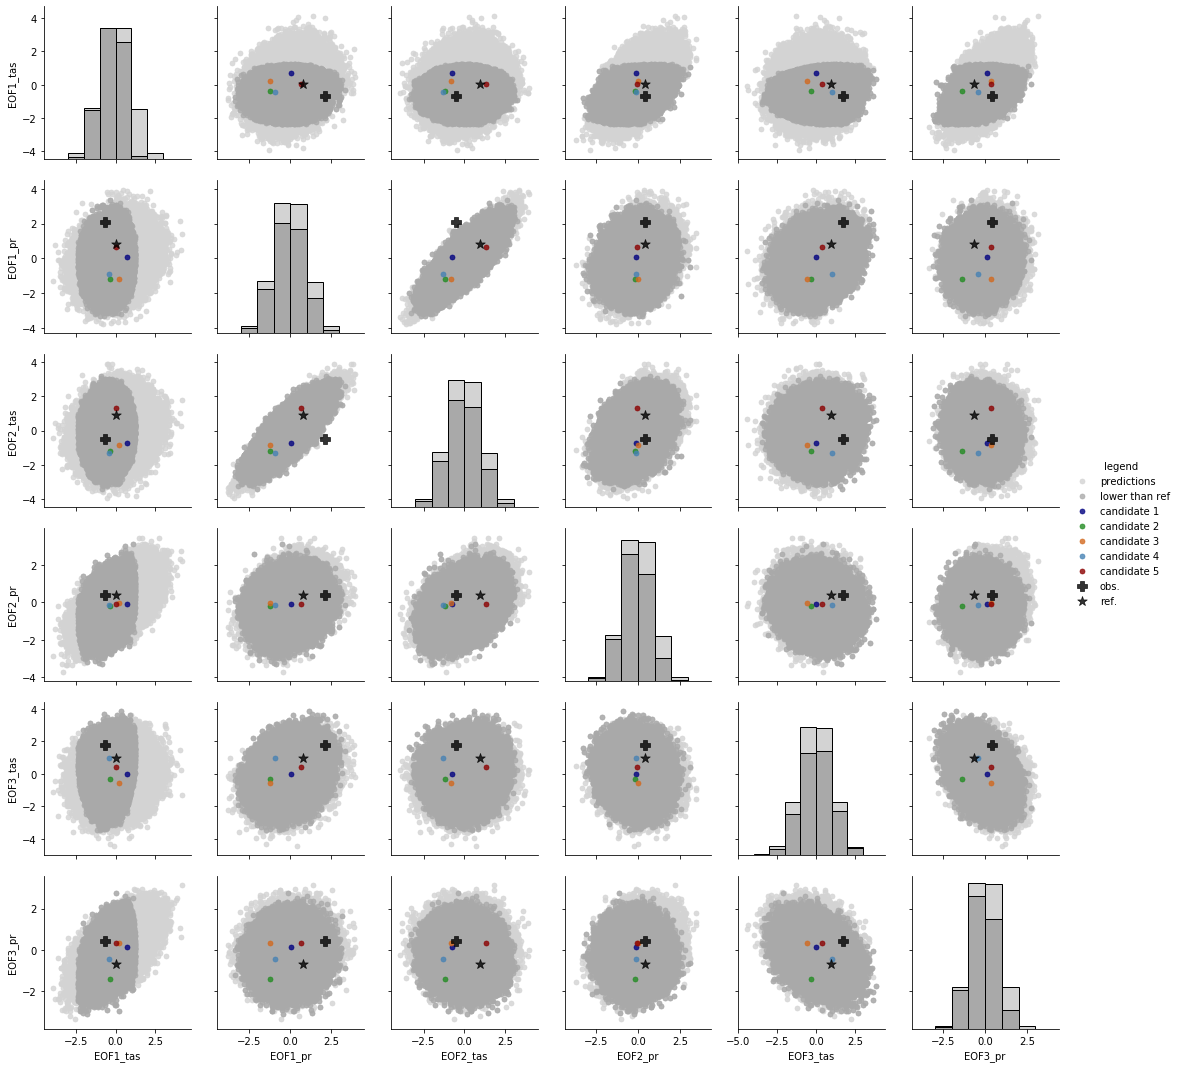

In [152]:
plt.figure(figsize=(15, 15))
    
variables = ['EOF1_tas', 'EOF1_pr', 'EOF2_tas', 'EOF2_pr', 'EOF3_tas', 'EOF3_pr']
p = ['lightgray',  'darkgray','navy', 'forestgreen', 'chocolate', 'steelblue', 'darkred',
     'black', 'black']
m = ['.','.', '.', '.', '.', '.', '.', 'P', '*']
n = [-4,-3,-2,-1,0,1,2,3,4]

sns.pairplot(df_fig, vars=variables, hue="legend", diag_kind='hist', 
             palette=p, 
             markers=m,
             plot_kws=dict(edgecolor=None , s=100, alpha=0.8), 
             diag_kws=dict(edgecolor='black', bins=n))

# Save figure ---------------
name_fig='Candidates_multi_meth1_EOF.png'
plt.savefig("/data/home/globc/peatier/PPE/figures/"+name_fig, 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)
#----------------------------



plt.show()

# Identify calibrations for simulations 

In [28]:
df_candidates = pd.read_pickle(path_files+'npy/Candidates_tas.npy')
df_candidates['index']

1    70483.0
2    27148.0
3    49594.0
4    32895.0
5    44705.0
Name: index, dtype: float64

In [30]:
df_candidates = pd.read_pickle(path_files+'npy/Candidates_tas.npy')
for i in df_candidates['index']

array([[ 1.06690559, -0.80864907, -1.20495813, ...,  0.35059887,
        -0.69523801, -0.94052341],
       [-0.6868159 , -1.68373542,  0.05488491, ..., -0.26054105,
        -0.84167958,  1.65214998],
       [-0.13255469,  1.41959649, -0.06857148, ...,  1.71118198,
        -0.25010546, -1.66849674],
       ...,
       [ 1.40696829, -0.74360007,  0.05067805, ..., -1.30229692,
        -1.13007354, -1.28834336],
       [-0.52222527, -0.64619873, -1.46604965, ...,  0.73659131,
        -1.47719654, -1.40830002],
       [ 1.62366953, -0.82375762, -0.5057191 , ..., -1.6861202 ,
         0.78220783,  1.44067753]])

In [37]:
path = "/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy"
LHS = np.load(file=path+"/LHS100000_param.npy")
df_LHS = pd.DataFrame(LHS)
df_candidates = pd.read_pickle(path_files+'npy/Candidates_tas.npy')
cand_x = []
for i in df_candidates['index'] :
    cand_x_tmp = df_LHS.iloc[int(i)]
    cand_x.append(cand_x_tmp)

In [41]:
xr_cand_x = array(cand_x)

In [42]:
## -- Save in .txt file 
path = '/data/home/globc/peatier/CNRMppe_error_decomposition/files/txt'
np.savetxt(path+'/Candidates_tas_x.txt', xr_cand_x)

# ------------- End of Selection ------------

## Analysis of CNRM-CM candidates runs

In [80]:
def get_3D_tas_xarr(path, filename, variables):
#    “”"
#    This function read the netCDF file of monthly data, compute the radiative budget, perform a yearly mean and 
#    return a dataframe
#    “”"
    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    #
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    tas = df['tas']
    #
    return tas

In [81]:
def reconstruct_X(eofs_combined, pc, nb_dims) :
    X_rec_tmp = np.dot(eofs_combined.transpose(),pc)
    if nb_dims == 3 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat", "time"]).transpose('time', 'lat', 'lon')
    if nb_dims == 2 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat"]).transpose('lat', 'lon')
    ## -- Because ARPEGE on Belenos does not have exactly the same grid as ARPEGE on Beaufix 
    X_rec['lat'] = eofs_combined['lat']
    X_rec['lon'] = eofs_combined['lon']
    return X_rec

In [82]:
nb_p_select = ['p901', 'p902', 'p903', 'p904']

In [83]:
## -- CNRM-CM candidates simulations :
filename='*_amip_*.nc'
amip_select=[]
for p in nb_p_select :
    path=path_PPE+'ENSEMBLE5/CNRM-CM6-1_amip_PPE_ENSEMBLE5/CNRM-CM6-1_amip_r1i1'+p+'f2/'
    amip_tmp = get_3D_tas_xarr(path, filename, variables)
    amip_select.append(amip_tmp)

In [84]:
## --Analysis of the candidates  :
e_sel_list = []
U_sel_list = []
X_sel_rec_list = []
p_sel_list = []
for X_sel in amip_select :
    ## -- Because ARPEGE on Belenos does not have exactly the same grid as ARPEGE on Beaufix :
    X_sel['lat'] = eofs_combined['lat']
    X_sel['lon'] = eofs_combined['lon']
          
    ## -- Full error RMSE : 
    e_sel = RMSE(X_sel, obs[variable_obs], W_rmse_2D)
    e_sel_list.append(e_sel)
    
    ## -- Project the candidates :
    X_sel_w = (X_sel - Mean)*W_eof_2D
    U_sel = solver.projectField(X_sel_w, neofs=18, weighted=False, eofscaling=1)
    U_sel_list.append(U_sel)
    
    ## --Reconstruct the candidates :
    X_sel_rec = reconstruct_X(eofs_combined, pc=U_sel, nb_dims=2)
    X_sel_rec_list.append(X_sel_rec)
    
    ## -- Parametric errors RMSE_rec : 
    p_sel = RMSE_rec(X_sel_rec, X_obs_w, Mean, W_rmse_2D)
    p_sel_list.append(float(p_sel))

In [85]:
## -- Faire DataFrame :
df_sel = pd.DataFrame([None]*4, columns= ['index'])

for i in range(0,18,1) :
    U_sel_df = []
    U_sel_df.append(float(U_sel_list[0][i]))
    U_sel_df.append(float(U_sel_list[1][i]))
    U_sel_df.append(float(U_sel_list[2][i]))
    U_sel_df.append(float(U_sel_list[3][i]))
    
    df_sel['EOF '+str(i+1)] = U_sel_df
    
df_sel['p'] = p_sel_list
df_sel

,index,EOF 1,EOF 2,EOF 3,EOF 4,EOF 5,EOF 6,EOF 7,EOF 8,EOF 9,EOF 10,EOF 11,EOF 12,EOF 13,EOF 14,EOF 15,EOF 16,EOF 17,EOF 18,p
0,None,-0.600673,-1.628882,2.834429,0.136754,0.308275,-1.767404,-0.205207,0.171683,0.009046,-0.749631,-0.865664,0.363790,-0.200908,-1.772613,1.074404,-1.329525,-1.080801,1.869777,1.271452
1,None,-0.468910,-0.608184,0.432991,0.421981,-0.038227,1.266231,-0.194175,-0.338823,0.460896,0.086062,-0.978331,-0.165585,1.316583,-0.326901,-0.181695,-0.962893,0.069598,-0.033189,1.333681
2,None,-0.330980,-0.299073,2.033083,-0.981662,0.784916,0.020647,-0.343419,-0.518185,-0.218918,-0.406787,-1.151575,0.886200,-1.013706,-2.062732,0.103687,-0.218105,-1.398216,0.509774,1.248067
3,None,-1.429836,-1.664361,0.011280,0.484553,0.580557,-0.464069,-1.001579,-0.906295,-0.143870,0.156267,-1.231842,0.197991,0.569985,-0.453556,0.601147,-0.268341,-1.313195,0.305790,1.432909


## Figure

### Concatenate everything in a big Data Frame 

In [93]:
Names= ['index']
for i in range(1,19,1) : 
    tmp = 'EOF '+str(i)
    Names.append(tmp)
Names.append('p')
#Names

In [94]:
## -- Emulated members
df_pc_pred = pd.DataFrame(np.load(path_files+'npy/df_pc_pred.npy'), columns=Names[1:])
df_fig = df_pc_pred.copy().reset_index()
df_fig['Legend'] = ['Emulated members']*len(df_fig)
#df_fig

In [95]:
## -- Members with lower error than reference
df_pc_low = pd.DataFrame(np.load(path_files+'npy/df_pc_low.npy'), columns=Names)
df_pc_low['Legend'] = ['$p_{tas}(\\theta_i)<p_{tas}(\\theta_0)$']*len(df_pc_low)
df_fig = df_fig.append(df_pc_low)
#df_fig

In [96]:
## -- Observations 
U_obs_list = []
Names = []
cpt=1
cols = ['index']
for i in U_obs.values :
    U_obs_list.append(float(i))
    tmp = 'EOF '+str(cpt)
    cols.append(tmp)
    Names.append(tmp)
    cpt+=1
df_obs = pd.DataFrame([U_obs_list], columns=Names)
df_obs['index'] = 0
df_obs['p'] = 0
df_obs['Legend'] = 'BEST observations'
cols.append('p')
cols.append('Legend')
df_obs_sort = df_obs[cols]
df_fig = df_fig.append(df_obs_sort)
#df_fig

In [97]:
## -- Reference CNRM-CM6-1
U_p1_list = []
for i in U_p1.values : 
    U_p1_list.append(float(i))
df_p1 = pd.DataFrame([U_p1_list], columns=Names)
df_p1['index'] = 0
df_p1['p'] = p_p1
df_p1['Legend'] = 'CNRM-CM6-1 ref.'
df_p1_sort = df_p1[cols]
df_fig = df_fig.append(df_p1_sort)
#df_fig

In [98]:
## -- Emulated candidates
df_pc_best = np.load(path_files+'npy/Candidates_tas.npy', allow_pickle=True)
names = []
for i in range(1, 6, 1) :
    tmp = 'Emulated candidate '+str(i)
    names.append(tmp)
df_pc_best['Legend'] = names 
df_fig = df_fig.append(df_pc_best)
#df_fig

In [99]:
## -- CNRM-CM candidates 
names=[]
for i in range(1,5,1) :
    tmp = 'CNRM-CM candidates '+str(i+1)
    names.append(tmp)
df_sel['Legend'] = names 
df_fig = df_fig.append(df_sel)
df_fig

,index,EOF 1,EOF 2,EOF 3,EOF 4,EOF 5,EOF 6,EOF 7,EOF 8,EOF 9,...,EOF 11,EOF 12,EOF 13,EOF 14,EOF 15,EOF 16,EOF 17,EOF 18,p,Legend
0,0,0.053160,0.591416,0.177104,0.866376,0.718467,0.659540,-0.043037,0.556143,0.368303,...,0.433413,1.109543,0.321661,1.513375,0.452024,-0.274895,-0.594091,0.293428,1.03628,Emulated members
1,1,-0.259237,0.647073,-0.452515,1.409053,0.870643,0.667772,-1.261793,-0.218841,-0.226251,...,-0.687209,-0.269193,0.721731,1.066529,-0.923241,1.317171,0.553031,-0.158446,1.10078,Emulated members
2,2,-0.050450,0.146491,-1.425103,-0.870566,-0.249998,-0.354165,-0.285270,-1.353141,0.577560,...,0.106225,1.624095,0.920702,1.138463,1.913375,-1.009275,0.666004,-0.200700,1.38931,Emulated members
3,3,1.133615,-1.250214,-1.322137,1.910634,1.905300,0.142851,-0.127473,0.419342,0.802691,...,-0.373750,-0.253786,-0.894195,-0.389659,-0.691261,0.796069,0.045508,0.170146,2.3142,Emulated members
4,4,-0.657846,-0.100945,2.477285,-0.208477,-0.485037,-0.204115,-0.430936,-0.878425,0.267369,...,0.385899,1.002614,0.633993,1.667335,0.034571,-0.438587,-0.113232,-0.295158,0.807454,Emulated members
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,44705,-1.622920,-0.500421,-0.435313,0.831580,0.855267,-0.538224,-0.478114,0.727354,-0.755861,...,-0.695699,-0.361838,-0.502221,0.211858,0.861333,0.502769,-0.536147,0.069069,1.02419,Emulated candidate 5
0,None,-0.600673,-1.628882,2.834429,0.136754,0.308275,-1.767404,-0.205207,0.171683,0.009046,...,-0.865664,0.363790,-0.200908,-1.772613,1.074404,-1.329525,-1.080801,1.869777,1.27145,CNRM-CM candidates 2
1,None,-0.468910,-0.608184,0.432991,0.421981,-0.038227,1.266231,-0.194175,-0.338823,0.460896,...,-0.978331,-0.165585,1.316583,-0.326901,-0.181695,-0.962893,0.069598,-0.033189,1.33368,CNRM-CM candidates 3
2,None,-0.330980,-0.299073,2.033083,-0.981662,0.784916,0.020647,-0.343419,-0.518185,-0.218918,...,-1.151575,0.886200,-1.013706,-2.062732,0.103687,-0.218105,-1.398216,0.509774,1.24807,CNRM-CM candidates 4


<Figure size 1080x1080 with 0 Axes>

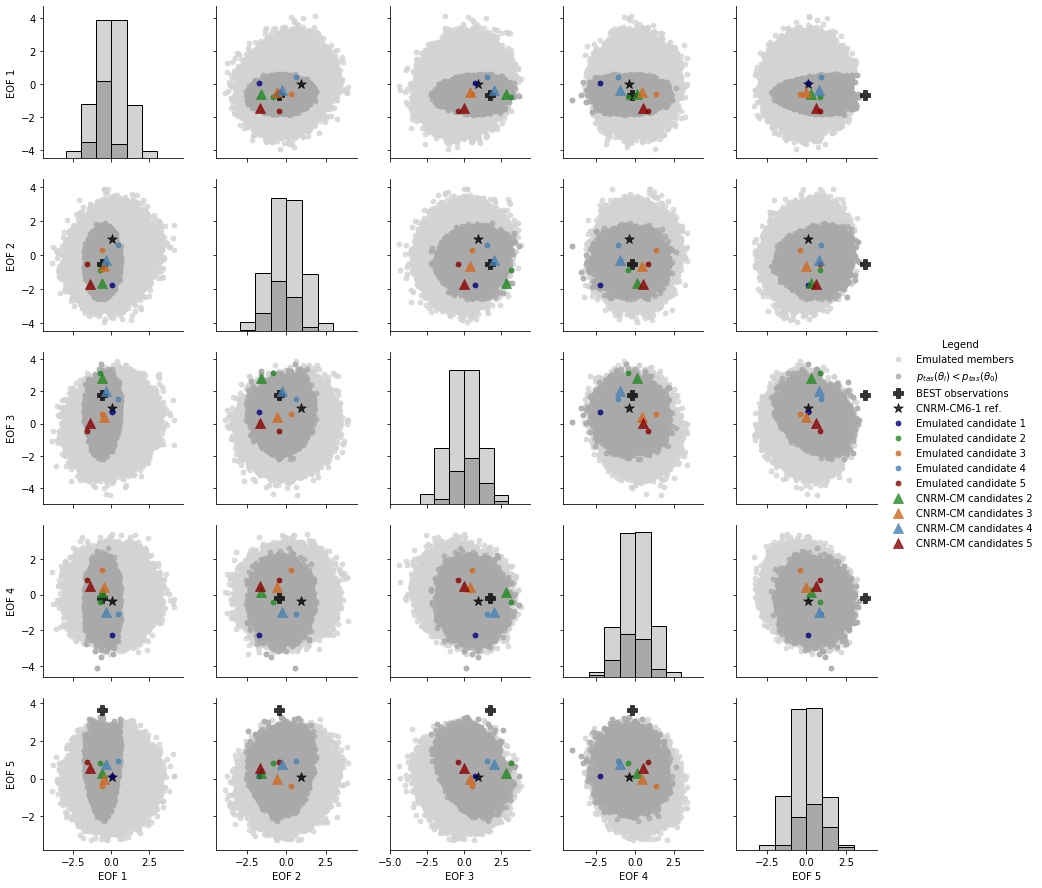

In [101]:
plt.figure(figsize=(15, 15))
    
variables = ['EOF 1', 'EOF 2', 'EOF 3', 'EOF 4', 'EOF 5']
p = ['lightgray',  'darkgray','black', 'black', 
     'navy', 'forestgreen', 'chocolate', 'steelblue', 'darkred', 
     'forestgreen', 'chocolate', 'steelblue', 'darkred' ]
m = ['.','.', 'P','*', 
     '.', '.', '.', '.', '.',
     '^', '^', '^', '^']
n = [-4,-3,-2,-1,0,1,2,3,4]

sns.pairplot(df_fig, vars=variables, hue="Legend", diag_kind='hist', 
             palette=p, 
             markers=m,
             plot_kws=dict(edgecolor=None , s=100, alpha=0.8), 
             diag_kws=dict(edgecolor='black', bins=n))

# Save figure ---------------
name_fig='Candidates_tas_EOF.png'
plt.savefig("/data/home/globc/peatier/figures/"+name_fig, 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)
#----------------------------



plt.show()

# Spatial maps CNRM-CM candidates

In [44]:
def diff_3D_rec(rec_anom_mod_w, rec_anom_obs_w, Mean, W_rmse_2D) :
    
    mod = rec_anom_mod_w/W_eof_2D + Mean
    obs = rec_anom_obs_w/W_eof_2D + Mean
    diff = mod - obs
    
    return diff
    

In [45]:
e_diff=[]
p_diff=[]
u_diff=[]
cpt=0
for X_sel in amip_select : 
    ## -- Because ARPEGE on Belenos does not have exactly the same grid as ARPEGE on Beaufix :
    X_sel['lat'] = eofs_combined['lat']
    X_sel['lon'] = eofs_combined['lon']
    
    ## -- 3D full error [obs - mod]
    e_diff_tmp = (obs[variable_obs] - X_sel)
    e_diff.append(e_diff_tmp)
    
     ## -- Project the candidates :
    X_sel_w = (X_sel - Mean)*W_eof_2D
    U_sel = solver.projectField(X_sel_w, neofs=18, weighted=False, eofscaling=1)
    
    ## --Reconstruct the candidates :
    X_sel_rec = reconstruct_X(eofs_combined[:,:,:], pc=U_sel[:], nb_dims=2)
    
    ## -- 3D p error [X_obs_rec - X_mod_rec]
    p_diff_tmp = diff_3D_rec(X_sel_rec, X_obs_rec, Mean, W_rmse_2D)
    p_diff.append(p_diff_tmp)
    
    ## -- 3D u error [e - p]
    u_diff_tmp = (e_diff_tmp - p_diff_tmp)
    u_diff.append(u_diff_tmp)

In [46]:
## -- Compute integrated metrics 
e_sel=[]
for X_sel in amip_select : 
    ## -- Because ARPEGE on Belenos does not have exactly the same grid as ARPEGE on Beaufix :
    X_sel['lat'] = eofs_combined['lat']
    X_sel['lon'] = eofs_combined['lon']
    
    ## -- Compute RMSE 
    e = RMSE(X_sel, obs[variable_obs], W_rmse_2D)
    e_sel.append(float(e))
df_sel['e'] = e_sel
df_sel

,index,EOF 1,EOF 2,EOF 3,EOF 4,EOF 5,EOF 6,EOF 7,EOF 8,EOF 9,...,EOF 12,EOF 13,EOF 14,EOF 15,EOF 16,EOF 17,EOF 18,p,Legend,e
0,None,-0.600673,-1.628882,2.834429,0.136754,0.308275,-1.767404,-0.205207,0.171683,0.009046,...,0.363790,-0.200908,-1.772613,1.074404,-1.329525,-1.080801,1.869777,1.271452,CNRM-CM candidates 1,1.312485
1,None,-0.468910,-0.608184,0.432991,0.421981,-0.038227,1.266231,-0.194175,-0.338823,0.460896,...,-0.165585,1.316583,-0.326901,-0.181695,-0.962893,0.069598,-0.033189,1.333681,CNRM-CM candidates 2,1.337315
2,None,-0.330980,-0.299073,2.033083,-0.981662,0.784916,0.020647,-0.343419,-0.518185,-0.218918,...,0.886200,-1.013706,-2.062732,0.103687,-0.218105,-1.398216,0.509774,1.248067,CNRM-CM candidates 3,1.269987
3,None,-1.429836,-1.664361,0.011280,0.484553,0.580557,-0.464069,-1.001579,-0.906295,-0.143870,...,0.197991,0.569985,-0.453556,0.601147,-0.268341,-1.313195,0.305790,1.432909,CNRM-CM candidates 4,1.447296


In [47]:
## -- p1 reference CNRM-CM6-1

## -- 3D full error [obs - mod]
e_diff_p1 = (obs[variable_obs] - p1_amip)

## -- Project 
X_p1 = p1_amip - Mean
X_p1_w = X_p1*W_eof_2D
U_p1 = solver.projectField(X_p1_w, neofs=18, weighted=False, eofscaling=1)

## --Reconstruct 
X_p1_rec = reconstruct_X(eofs_combined[:,:,:], pc=U_p1[:], nb_dims=2)

## -- 3D p error [X_obs_rec - X_mod_rec]
p_diff_p1 = diff_3D_rec(X_p1_rec, X_obs_rec, Mean, W_rmse_2D)

## -- 3D u error [e - p]
u_diff_p1 = (e_diff_p1 - p_diff_p1)

## Figure

In [48]:
def plot_map(dataset, var,  palette, xmin, xmax, label, title, name_fig) :
    
    lats = dataset['lat'][:]
    lons = dataset['lon'][:]

    var, lons = add_cyclic_point(var, coord=lons)


    fig = plt.figure(figsize=(10, 5))
    ax=plt.gca()
    ax = plt.axes(projection=ccrs.Robinson())

    plt.contourf(lons, lats, var, 
             transform=ccrs.PlateCarree())

    nb_color = abs(xmin)+abs(xmax)+3
    cmap = plt.get_cmap(palette)  
    
    mm = ax.pcolormesh(lons,\
                   lats,\
                   var,\
                   vmin=xmin,\
                   vmax=xmax, \
                   transform=ccrs.PlateCarree(),\
                   cmap=cmap )

    #m.colorbar()
    cbar = plt.colorbar(mm, orientation='vertical', drawedges=False, extend='both')

    cbar.set_label(label, size = 18, style = 'italic')
    ax.set_title(title, fontsize=18, 
             fontweight = 'bold')
    cbar.ax.tick_params(axis='both', which='major', labelsize=15)


    ax.coastlines()

    # Save figure ---------------
    plt.savefig("/data/home/globc/peatier/figures/"+name_fig, 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)
    #----------------------------

    plt.show()

## Reference p1

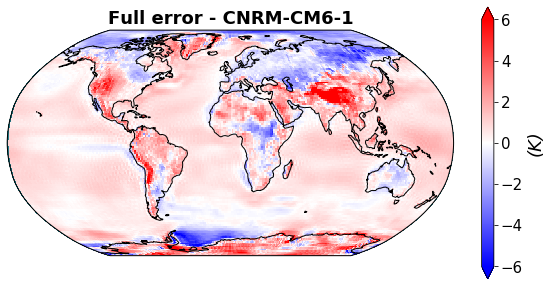

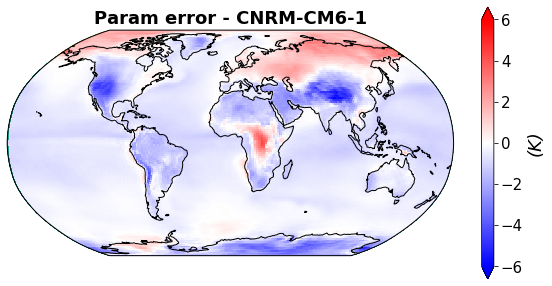

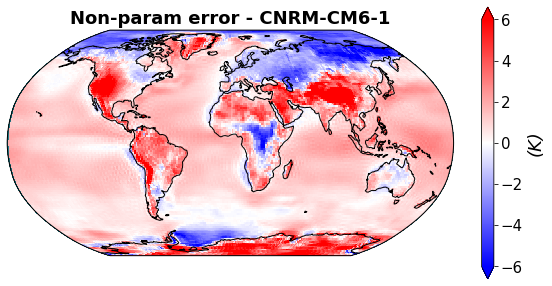

In [49]:
## -- full error e_p1 
dataset = e_diff_p1
var = dataset[:]
palette = "bwr"
xmin = -6
xmax = 6
label = '(K)'
title = 'Full error - CNRM-CM6-1'
name_fig = 'Fig4_full_error_'+variable+'_p1.png'

plot_map(dataset, var, palette, xmin, xmax, label, title, name_fig)

## -- param error p_p1 
dataset = p_diff_p1
var = dataset[:]
palette = "bwr"
xmin = -6
xmax = 6
label = '(K)'
title = 'Param error - CNRM-CM6-1'
name_fig = 'Fig4_param_error_'+variable+'_p1.png'

plot_map(dataset, var, palette, xmin, xmax, label, title, name_fig)

## -- non-param error u_p1 
dataset = u_diff_p1
var = dataset[:]
palette = "bwr"
xmin = -6
xmax = 6
label = '(K)'
title = 'Non-param error - CNRM-CM6-1'
name_fig = 'Fig4_non-param_error_'+variable+'_p1.png'

plot_map(dataset, var, palette, xmin, xmax, label, title, name_fig)

## CNRM-CM candidates 

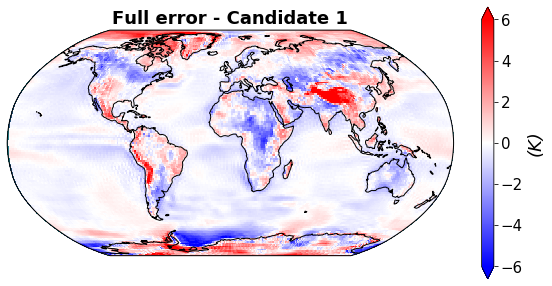

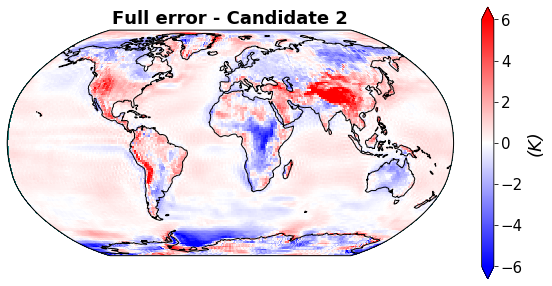

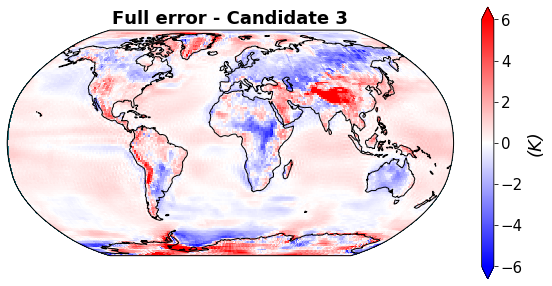

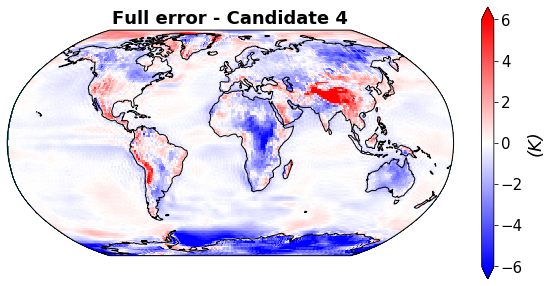

In [50]:
for i in range(0,4,1) :
    dataset = e_diff[i]
    var = dataset[:]
    palette = "bwr"
    xmin = -6
    xmax = 6
    label = '(K)'
    title = 'Full error - Candidate '+str(i+1)
    name_fig = 'Fig4_full_error_'+variable+'_candidate'+str(i+1)+'.png'

    plot_map(dataset, var, palette, xmin, xmax, label, title, name_fig)

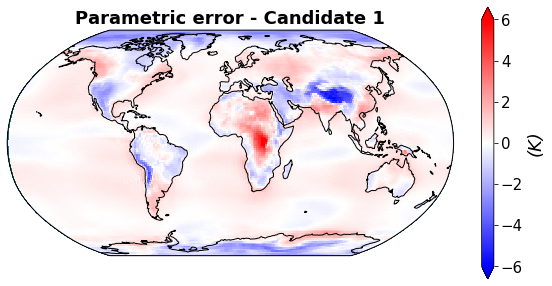

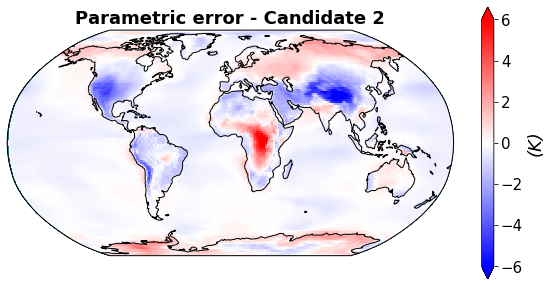

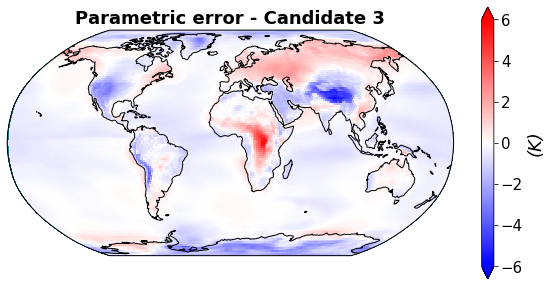

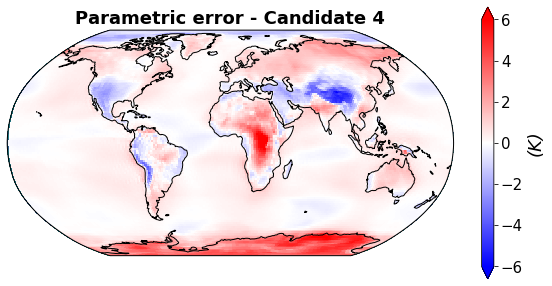

In [51]:
for i in range(0,4,1) :
    dataset = p_diff[i]
    var = dataset[:]
    palette = "bwr"
    xmin = -6
    xmax = 6
    label = '(K)'
    title = 'Parametric error - Candidate '+str(i+1)
    name_fig = 'Fig4_param_error_'+variable+'_candidate'+str(i+1)+'_q18.png'

    plot_map(dataset, var, palette, xmin, xmax, label, title, name_fig)

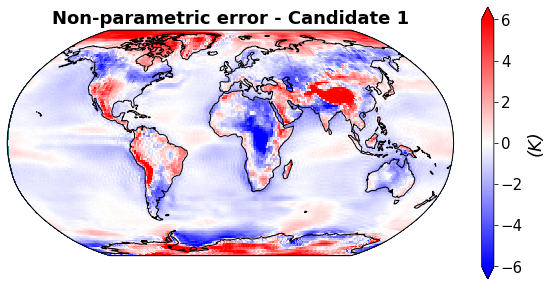

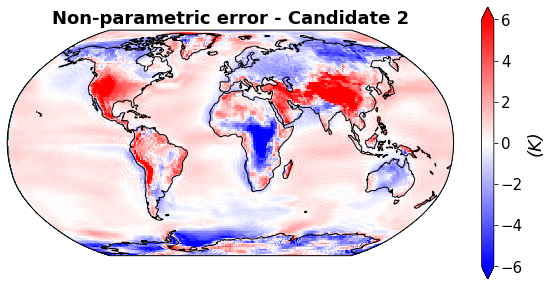

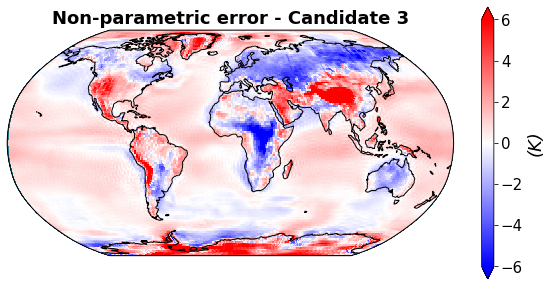

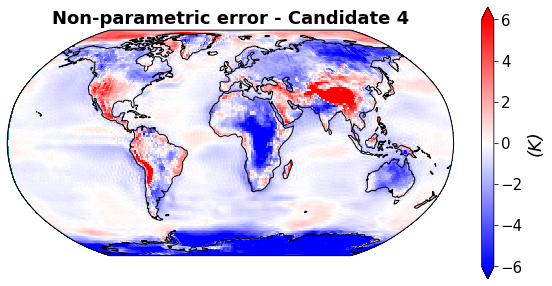

In [52]:
for i in range(0,4,1) :
    dataset = u_diff[i]
    var = dataset[:]
    palette = "bwr"
    xmin = -6
    xmax = 6
    label = '(K)'
    title = 'Non-parametric error - Candidate '+str(i+1)
    name_fig = 'Fig4_non-param_error_'+variable+'_candidate'+str(i+1)+'_q18.png'

    plot_map(dataset, var, palette, xmin, xmax, label, title, name_fig)

# Emulated candidates 

In [53]:
df_cand = np.load(path_files+'npy/Candidates_tas.npy', allow_pickle=True)

## -- Param. error 
p_diff_sel = []
for i in range(1,5,1) :
    U = df_cand.iloc[i][1:19].astype('float')
    
    ## --Reconstruct 
    X_sel_rec = reconstruct_X(eofs_combined[:,:,:], pc=U, nb_dims=2)
        
    ## -- 3D p error [X_obs_rec - X_mod_rec]
    p_diff = diff_3D_rec(X_sel_rec, X_obs_rec, Mean, W_rmse_2D)
    p_diff_sel.append(p_diff)

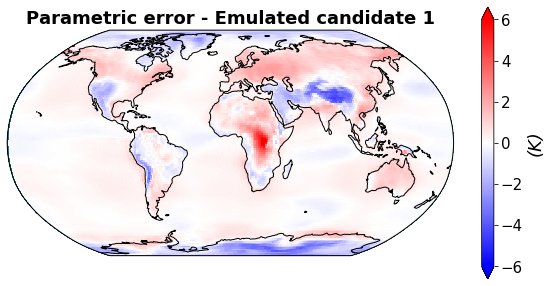

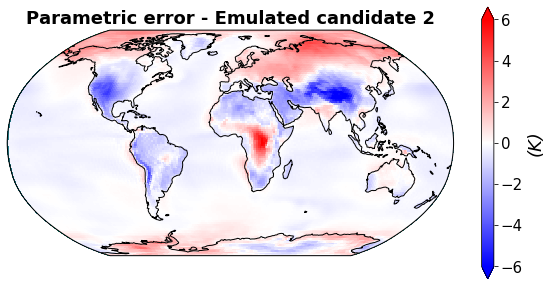

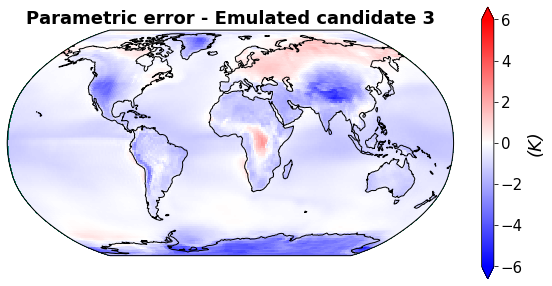

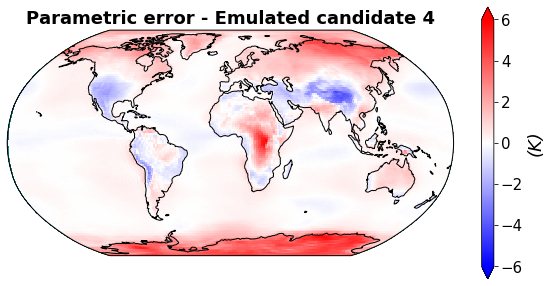

In [54]:
for i in range(0,4,1) :
    dataset = p_diff_sel[i]
    var = dataset[:]
    palette = "bwr"
    xmin = -6
    xmax = 6
    label = '(K)'
    title = 'Parametric error - Emulated candidate '+str(i+1)
    name_fig = 'Fig4_param_error_'+variable+'_emul_candidate'+str(i+1)+'_q18.png'

    plot_map(dataset, var, palette, xmin, xmax, label, title, name_fig)

In [55]:
sqrt(8)

2.8284271247461903

In [56]:
sqrt(4)+sqrt(4)

4.0